In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import pygraphviz
from pickle import load, dump
from collections import Counter
from tqdm import tqdm

plt.style.use(f"{os.environ['style']}")

with open(r'D:\dstore\nlp\w2v\fwords', 'rt') as f:
    full_words = Counter({f'_{x[1]}_': int(x[0]) for x in [x.strip().split() for x in f.readlines()]})
with open(r'D:\dstore\tmp\4', 'rb') as f:
    dsts = load(f)
with open(r'D:\dstore\tmp\5', 'rb') as f:
    tf2, rntp, drntp = load(f)

for x in [x for x in full_words if len(x) < 5]:
    full_words.pop(x)

for x in [x for x in full_words if "'" in x]:
    out = x.split("'")
    if f'{out[0]}_' in full_words:
        full_words[f'{out[0]}_'] += full_words[x]
    full_words.pop(x)

ldct = {
    'alpha': {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'},
    'unifx': {'s_', 'd_', 'r_', 'n_', 't_', 'x_', 'y_', 'a_', 'i_', 'o_', '_a', '_o', '_e', '_i'},
    'unifx_l': {'s_', 'y_', '_a', '_e'},
    'fdbl': {'b', 'c', 'd', 'f', 'g', 'l', 'm', 'n', 'p', 'r', 's', 't'},
    'bdbl': {'b', 'd', 'g', 'm', 'l', 'n', 'p', 'r', 't'},
    'avwls': {'a', 'e', 'i', 'o', 'u', 'y'},
    'bvwls': {'a', 'e', 'i', 'o', 'u'},
    'cvwls': {'a', 'e', 'o', 'i', 'y'},
    'dvwls': {'a', 'e', 'o', 'u'},
    'fvwls': {'a', 'o', 'i', 'u'},
    'uafxs': {'logy_', 'ity_', 'try_', 'cy_', 's_', 'y_'}
}

def get_str_idx(afx, word):
    idx, i = [], 0
    while i < len(word):
        try:
            idx.append(word[i:].index(afx))
        except ValueError:
            return [x+sum(idx[:j])+(len(afx)*len(idx[:j])) for j, x in enumerate(idx)]
        i += idx[-1]+len(afx)
    return [x+sum(idx[:j])+(len(afx)*len(idx[:j])) for j, x in enumerate(idx)]

def surrounds(afx, w=3, merge=False, exact=False):
    left_cnt, right_cnt = Counter(), Counter()
    if afx[0] == '_': pre = True
    else: pre = False
    if not exact:
        afx = afx.strip('_')
        targets = [x.strip('_') for x in full_words if afx in x]
    else:
        targets = [x for x in full_words if afx in x]
        if pre: targets = [x.rstrip('_') for x in targets]
        else: targets = [x.lstrip('_') for x in targets]
    aln = len(afx)

    for x in targets:
        xln = len(x)
        idxs = get_str_idx(afx, x)
        for i in idxs:
            left_cnt[x[max(i-w, 0):i]] += 1
            right_cnt[x[i+aln:i+aln+w]] += 1

    if '' in left_cnt: left_cnt.pop('')
    if '' in right_cnt: right_cnt.pop('')
    if merge or exact:
        for x in left_cnt: right_cnt[x] += left_cnt[x]
        return right_cnt
    else: return left_cnt, right_cnt

def kld(P, Q=None, dist=dsts['nd']):
    pcnt = Counter({x: 3 for x in ldct['alpha']})
    for x in P:
        for y in x: pcnt[y] += P[x]  
    psum = sum(x for x in pcnt.values())
    if Q:
        qcnt = Counter({x: 3 for x in ldct['alpha']})
        for x in Q:
            for y in x: qcnt[y] += Q[x]
        for x in ldct['alpha']:
            if pcnt[x] == 3 and qcnt[x] == 3:
                pcnt.pop(x)
                qcnt.pop(x)
        qsum = sum(x for x in qcnt.values())
        return sum([(pcnt[x] / psum) * np.log2((pcnt[x] / psum) / (qcnt[x] / qsum)) for x in pcnt])
    else:
        return sum([(pcnt[x] / psum) * np.log2((pcnt[x] / psum) / dist[x]) for x in pcnt])

def pulld(afx, len_lim=False):
    aln = len(afx)
    sub_set = [x for x in tf2 if afx in x]
    out = []
    for x in sub_set:
        i = 1
        if x[0] == '_':
            while len(x[:-i]) > aln:
                if x[:-i] in sub_set:
                    break
                i += 1
            else: out.append(x)
        else:
            while len(x[i:]) > aln:
                if x[i:] in sub_set:
                    break
                i += 1
            else: out.append(x)
    if not len_lim: return [x for x in out if x != afx]
    else: return [x for x in out if len(x) == len(afx)+1 and x != afx]

def pullu(afx):
    i = 1
    if afx[0] == '_':
        while i < len(afx):
            if afx[:-i] in tf2:
                return afx[:-i]
            i += 1
    else:
        while i < len(afx):
            if afx[i:] in tf2:
                return afx[i:]
            i += 1


In [ ]:
smalls = {x for x in full_words if len(x) > 4 and len(x) < 12}
bigs = {x for x in full_words if len(x) > 7}

tf2 = Counter()
for x in tqdm(smalls):
    x = x.strip('_')
    group = [y for y in bigs if x in y]
    for y in group:
        out = y.split(x)
        if len(out) > 2:
            out.append(f'_{out[1]}')
            out.append(f'{out[1]}_')
            out.pop(1)
        for z in out:
            if z not in ('_', ''):
                tf2[z] += 1
tf2 = Counter({x[0]: x[1] for x in tf2.most_common() if x[1] > 2})

rntp = {}
for x in tqdm(tf2):
    hold = []
    if x[0] == '_': si = 1
    else: si = 0
    if 4 < len(x) < 7: fd = dsts['md']
    elif (x[0] == '_' and len(x) > 6) or (x[-1] == '_' and len(x) < 5): fd = dsts['sd']
    else: fd = dsts['pd']
    for i in range(1, 4):
        dir = surrounds(x, i)[si]
        hold.append([kld(surrounds(x, i, merge=True)), kld(dir, dist=fd), kld(surrounds(x, i, exact=True), dist=fd)])
    rntp[x] = np.array(hold[::-1]).T

drntp = {}
for x in tqdm(tf2):
    above, below = pulld(x, True), pullu(x)
    if above: above = np.array([rntp[y] for y in above]).mean(axis=0)
    else: above = dsts['lr']
    if below: below = rntp[below]
    elif x[0] == '_': below = dsts['fr']
    else: below = dsts['br']
    middle = rntp[x]
    drntp[x] = (above-middle) - (middle-below)


In [ ]:
#Relative Entropy of Subwords Adjacent Characters
#When an affix appears in a word, what are the immediate characters that follow that affix?
#Low entropy indicates that an affix may be incomplete
#Low entropy followed by an immediate spike in entropy indicates a whole affix
#rntp[affix] reflects the relative entropy of characters surrounding an affix
#
#'g_' would have low entropy because 'n' almost always follows g at the end of a word
#For the edges, counting a character set at the ends of a word will give us a distribution to compare against

In [ ]:
afx = 'tion_'
words = pulld('tion_', True)
words.append(afx)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = np.array([[
    *[np.mean(x) for x in rntp[w]], 
    *[np.mean(x) for x in rntp[w].T], 
    *[np.mean(x) for x in drntp[w]], 
    *[np.mean(x) for x in drntp[w].T]
    ] for w in words])

for i, x in enumerate(yvars.T):
    ax.bar([w+((2/len(yvars[0]))*i) for w in range(0, len(words)*3, 3)], x, width=0.1)

plt.xticks([i+1 for i in range(0, len(yvars)*3, 3)], words)
print()

In [ ]:
afx = 'ng_'
fig, ax = plt.subplots(figsize=(16, 10))
dn = pullu(afx)
if dn: 
    d2n = pullu(dn)
    dn = dsc[dn]
else: dn = np.array([0]*6)
if d2n: d2n = dsc[d2n]
else: d2n = np.array([0]*6)
up, md = upper(afx), dsc[afx]
if len(up) > 0: u2p = upper(afx, 2)
else: up = np.array([0]*6)
if len(u2p) < 1: u2p = np.array([0]*6)

u2m, um, mm, dm, d2m = u2p.mean(), up.mean(), md.mean(), dn.mean(), d2n.mean()
yvars = [u2p, up, md, dn, d2n]
plt.xticks(range(len(yvars)), ['u2p', 'up', afx, 'dn', 'd2n'][::-1])
ax.plot(range(len(yvars)), yvars[::-1])
ax.scatter((0, 1, 2, 3, 4, 0, 1, 3, 4), (d2m, dm, mm , um, u2m, mm-d2m, mm-dm, um-mm, u2m-mm), c=['r', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g'])
ax.legend(['bidir', 'dir', 'xdir', 'win3', 'win2', 'win1'])

print(f'u2: {u2m}\nu: {um}\nmd: {mm}\ndn: {dm}\nd2: {d2m}')
print(f'u2m: {u2m-um}\nupm: {um-mm}\ndnm: {mm-dm}\nd2m: {mm-d2m}')

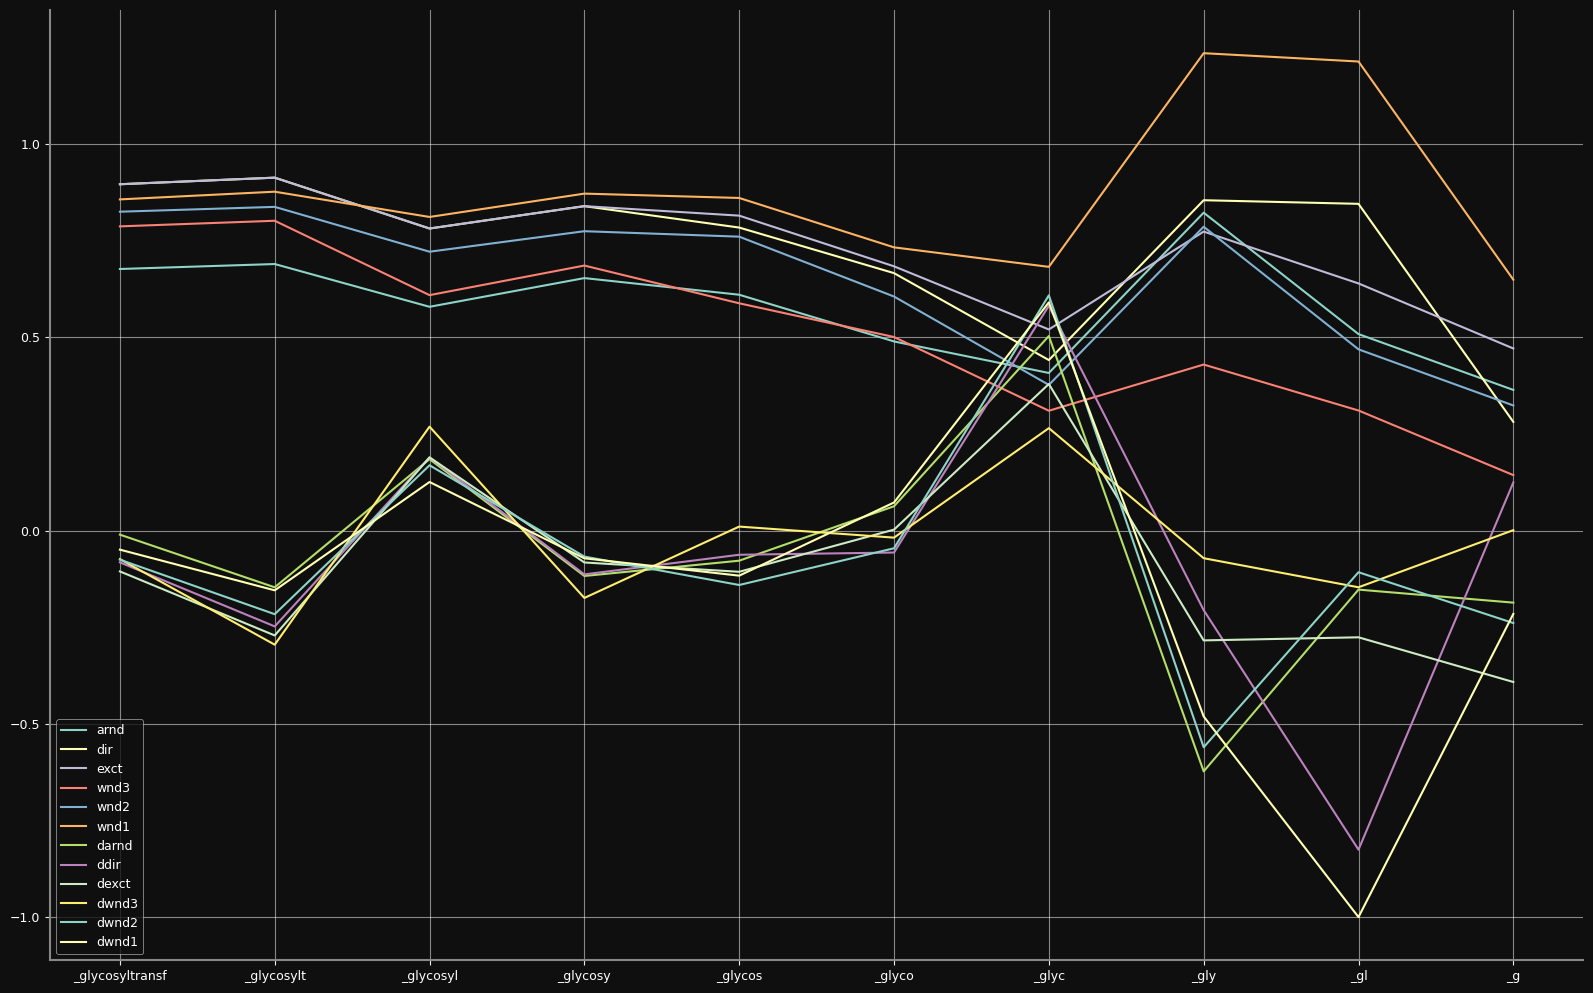

In [9]:
afx = '_glycosyltransf'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

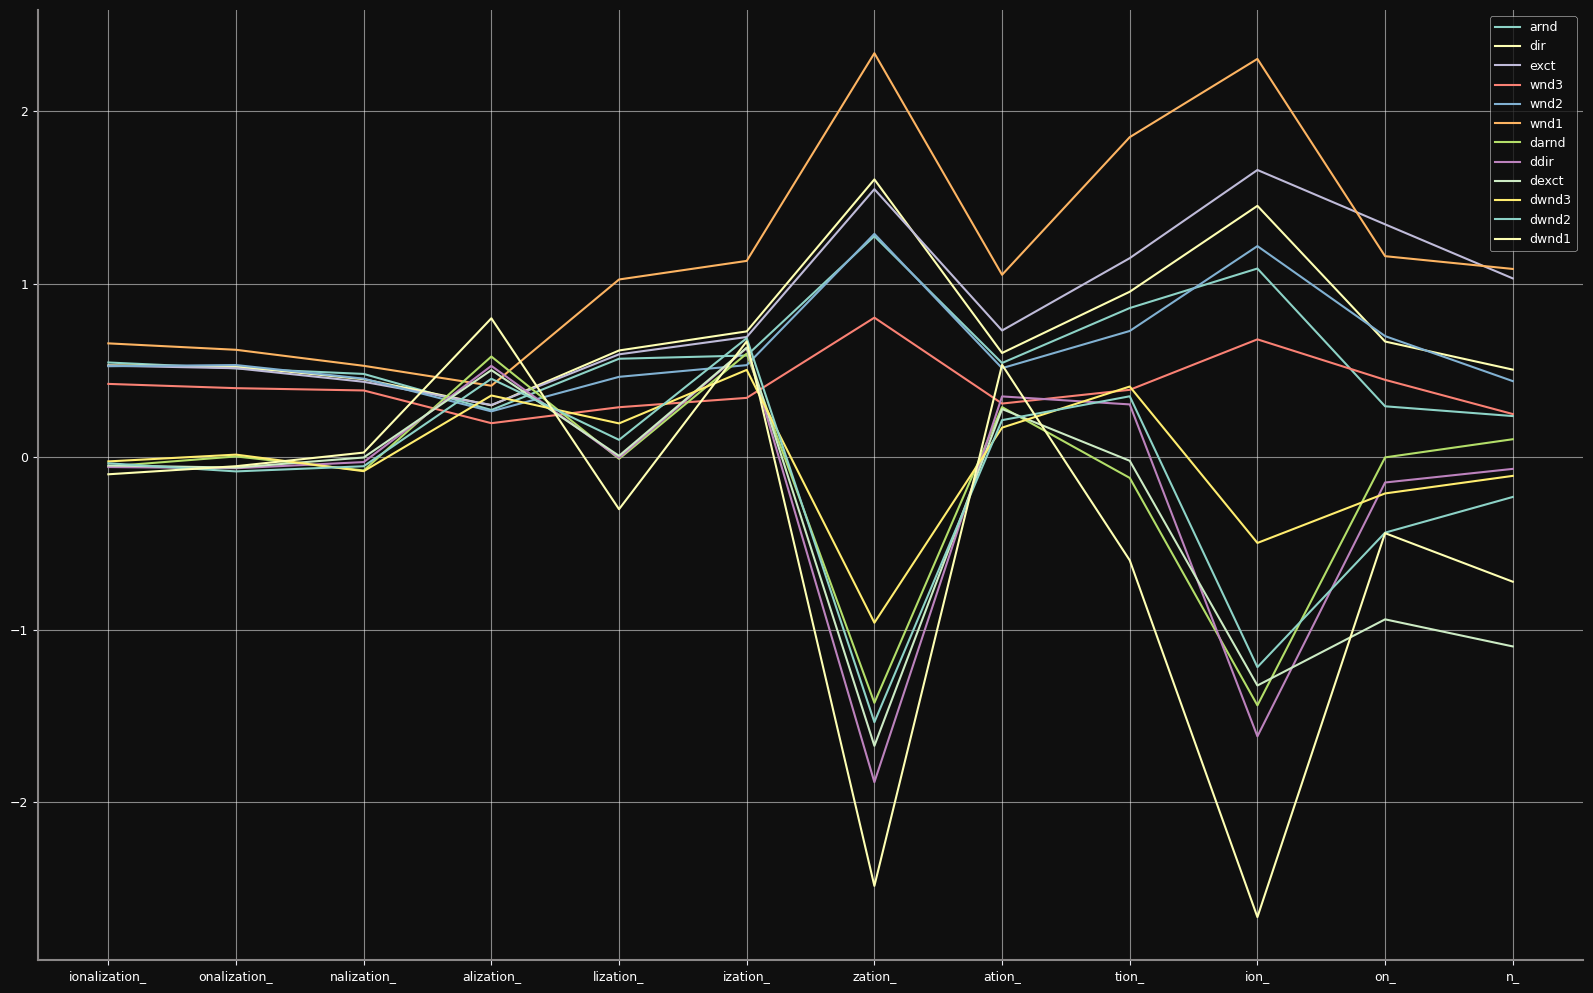

In [10]:
afx = 'ionalization_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

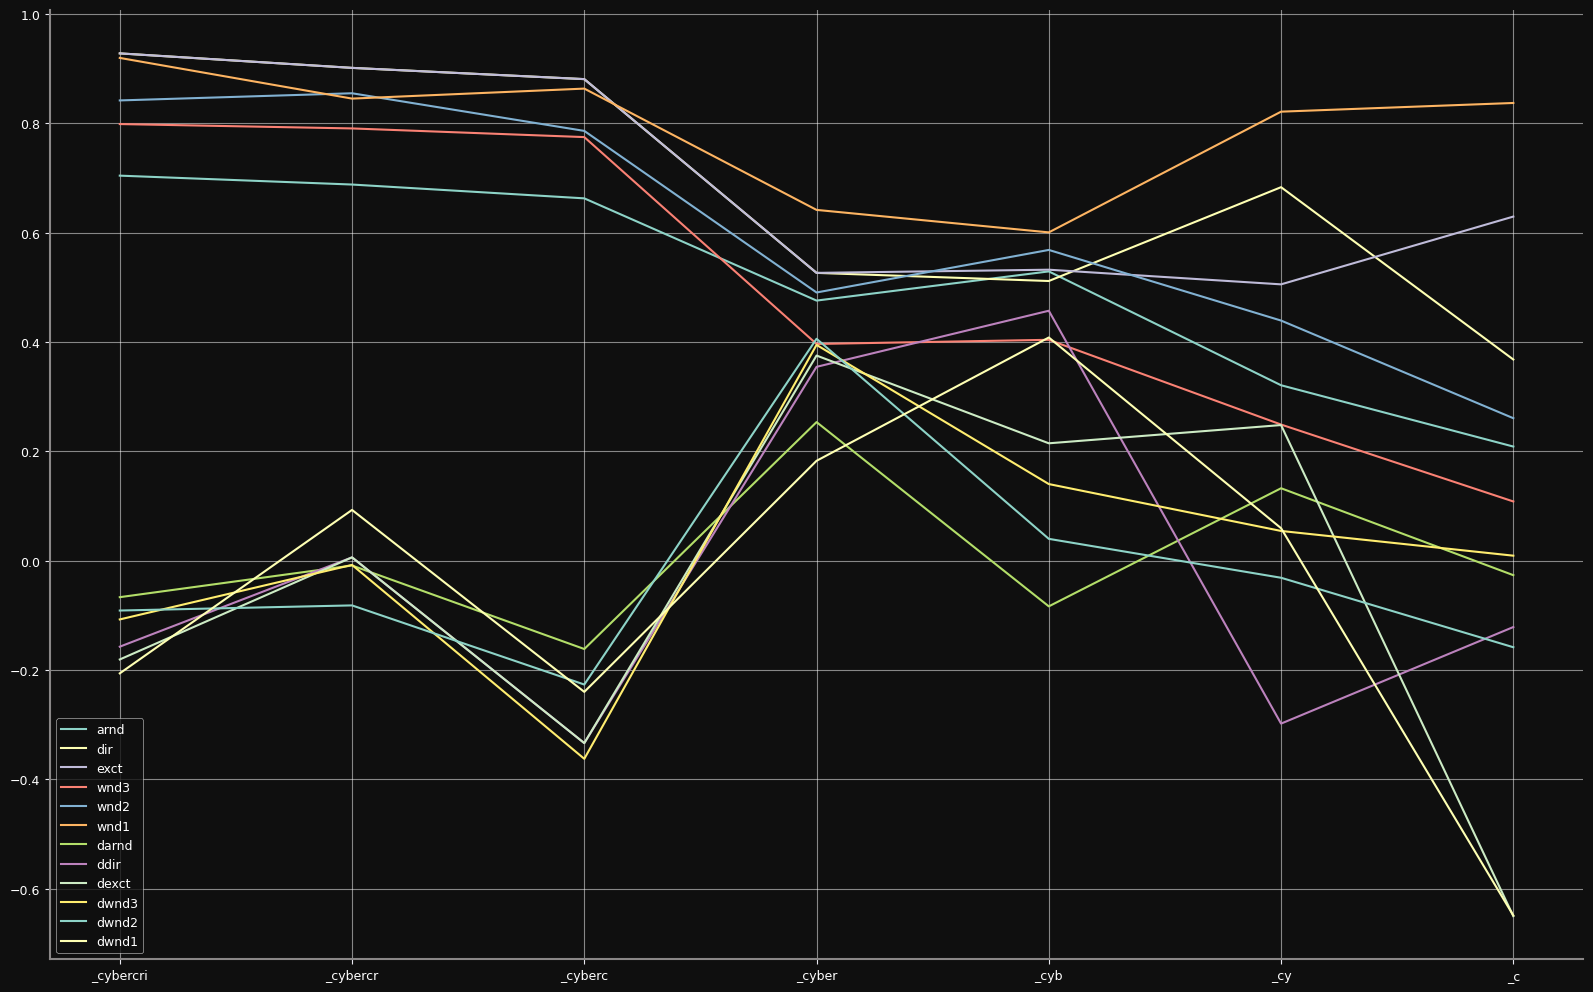

In [11]:

afx = '_cybercri'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

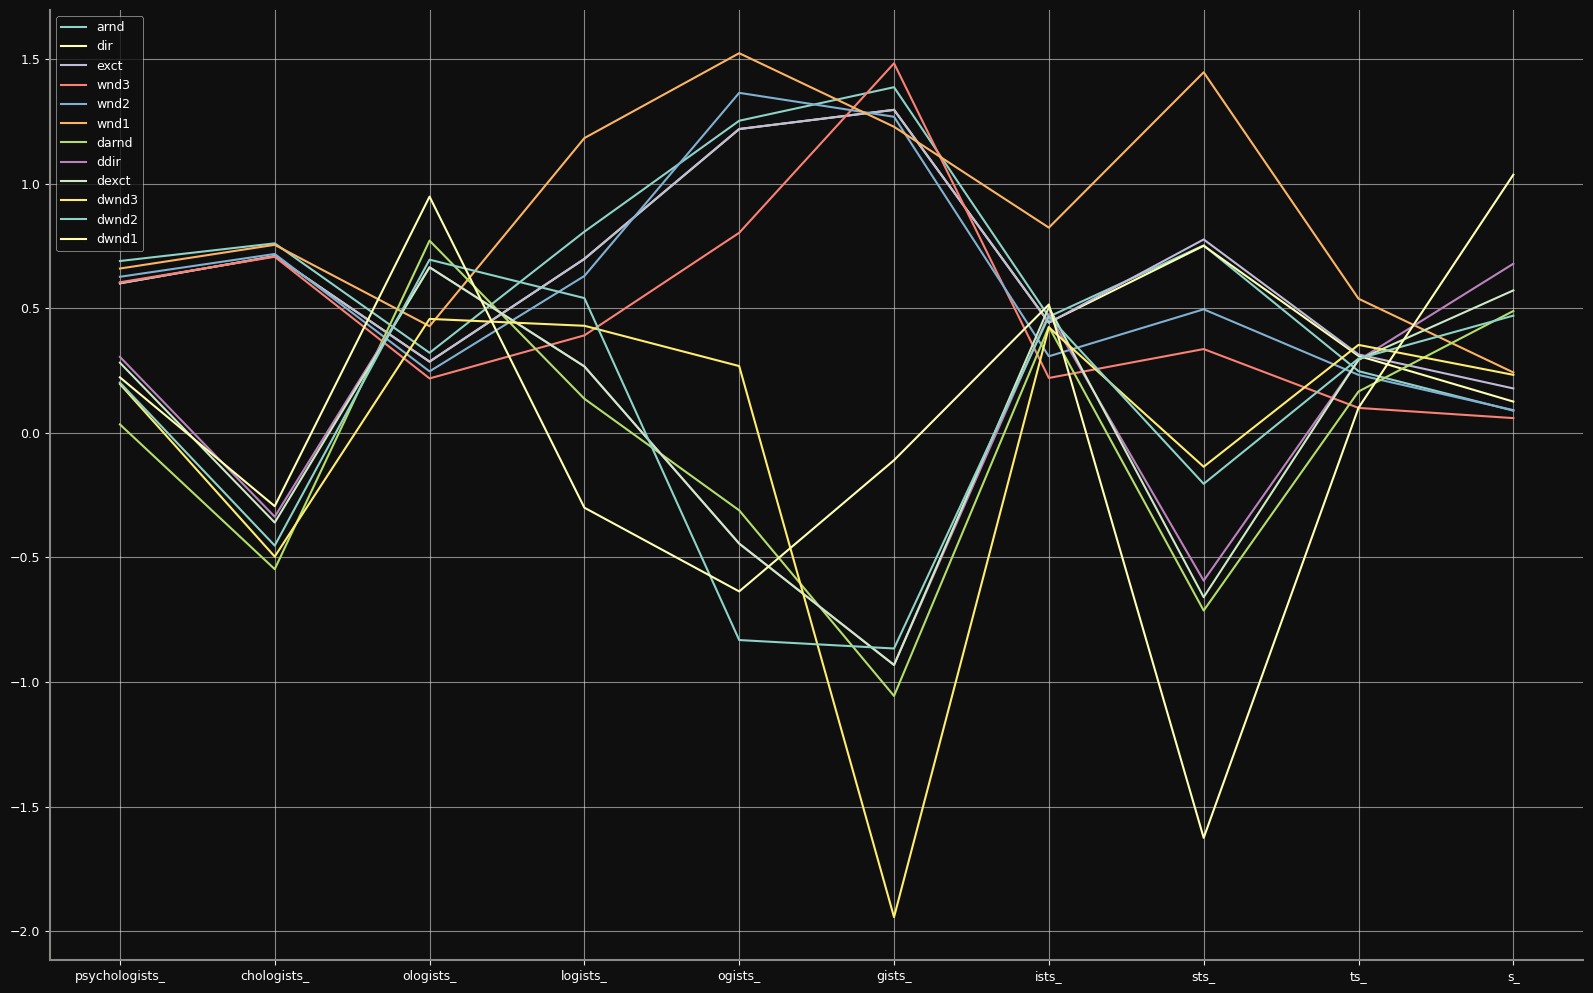

In [12]:

afx = 'psychologists_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

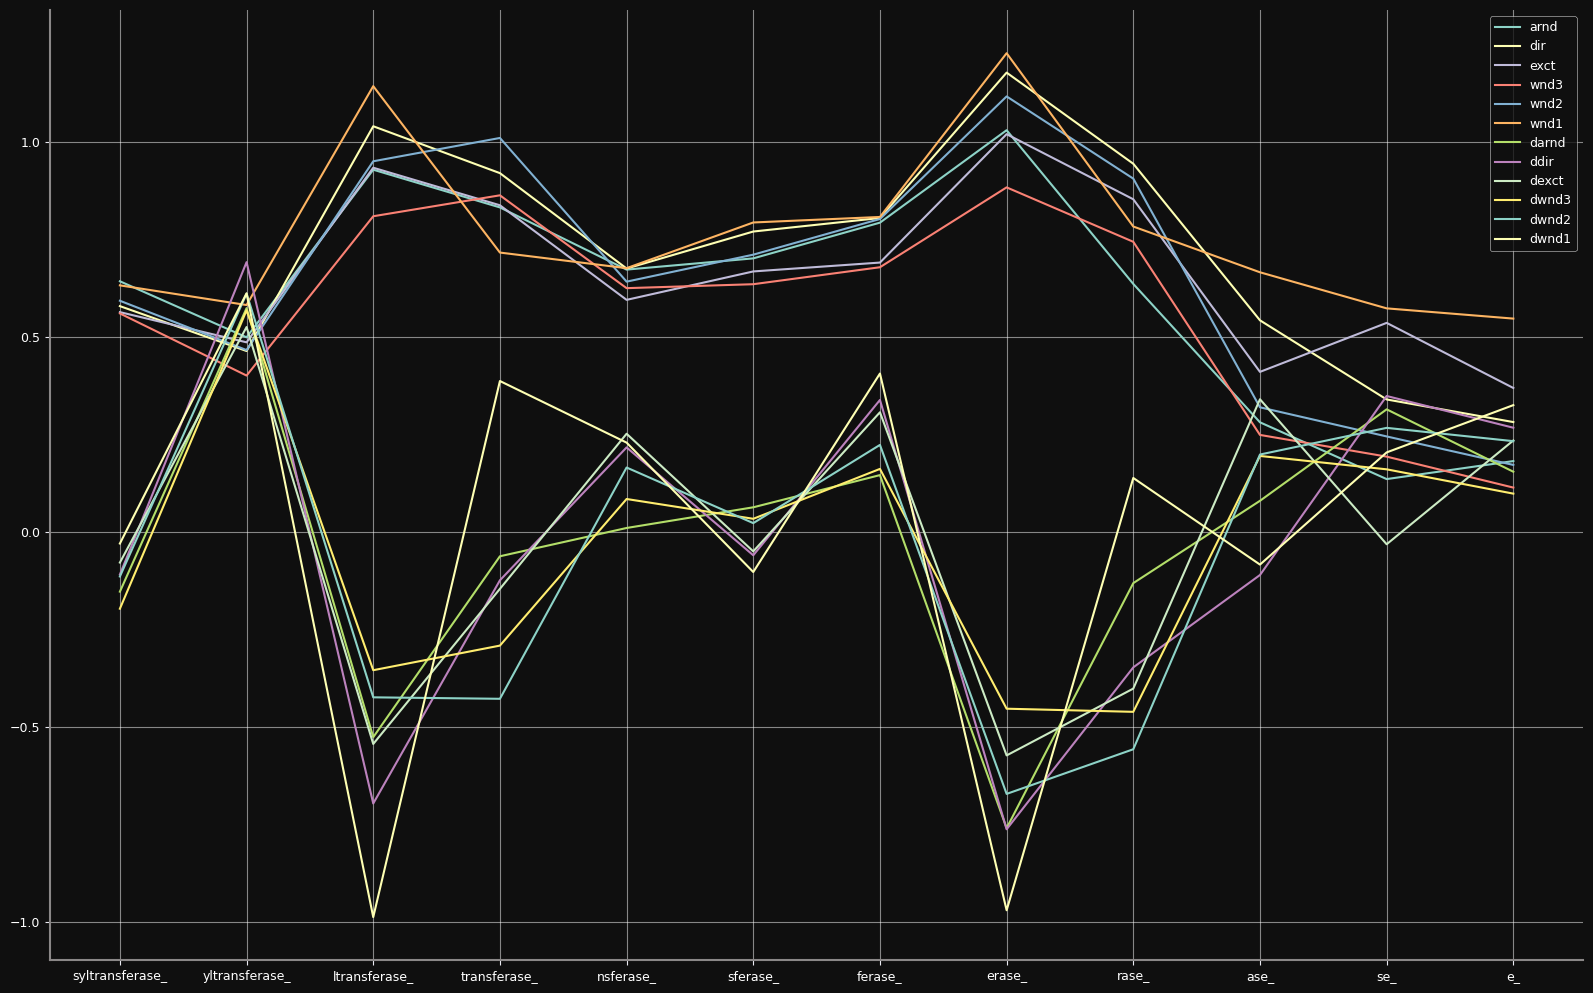

In [13]:
afx = 'syltransferase_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

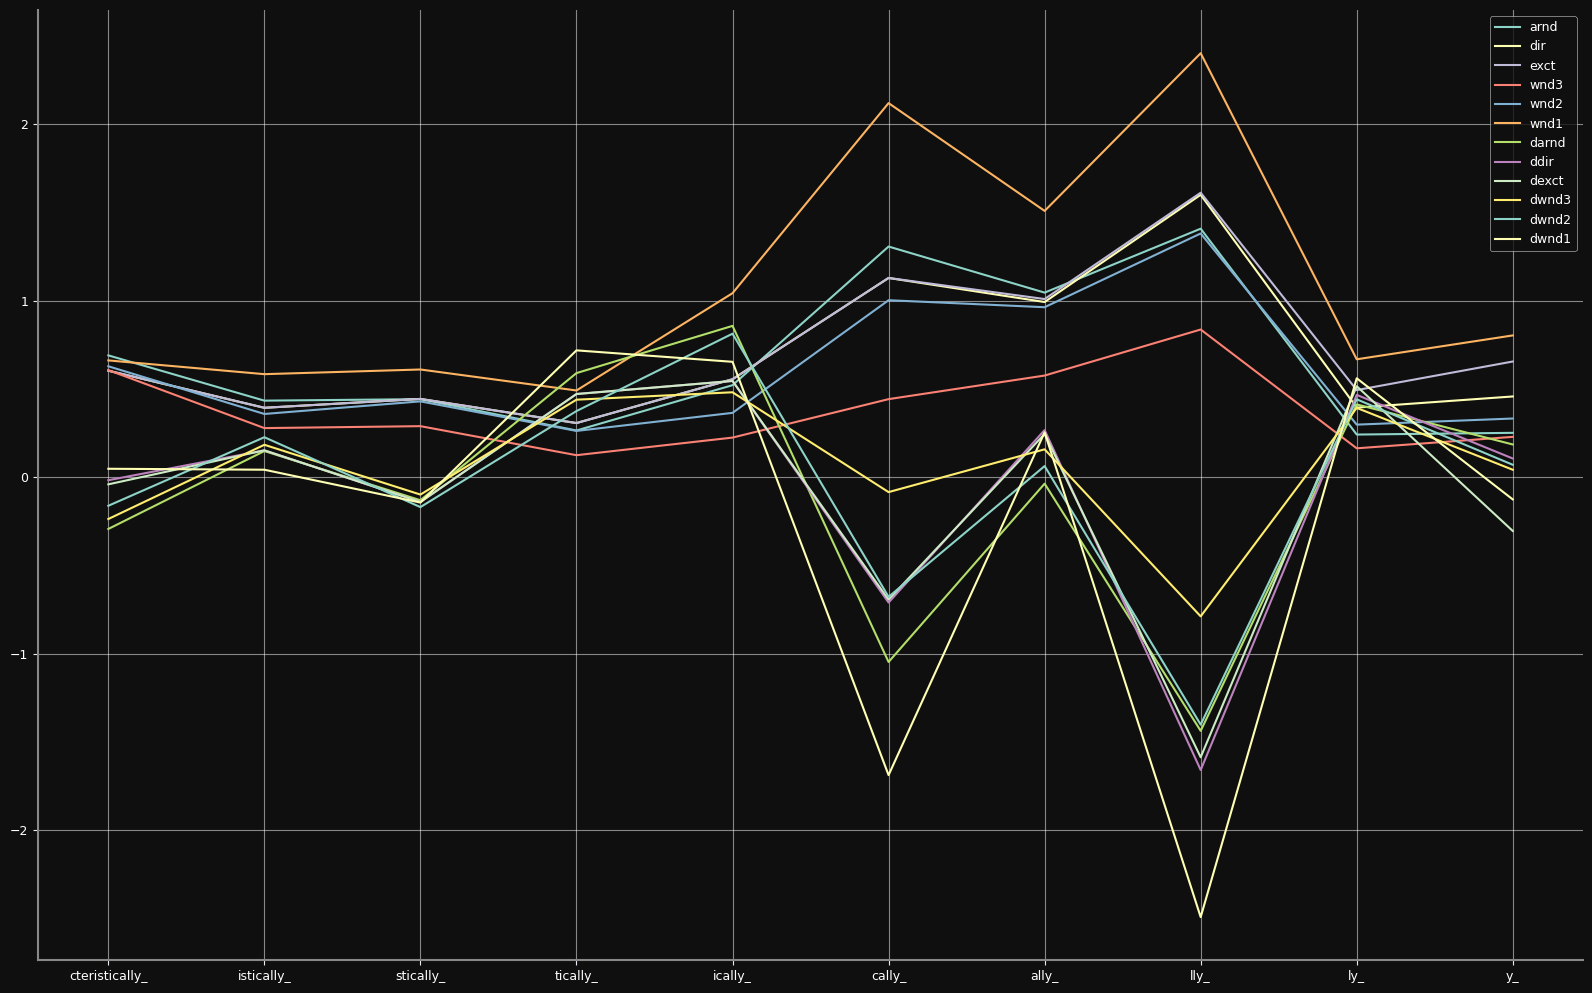

In [14]:

afx = 'cteristically_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

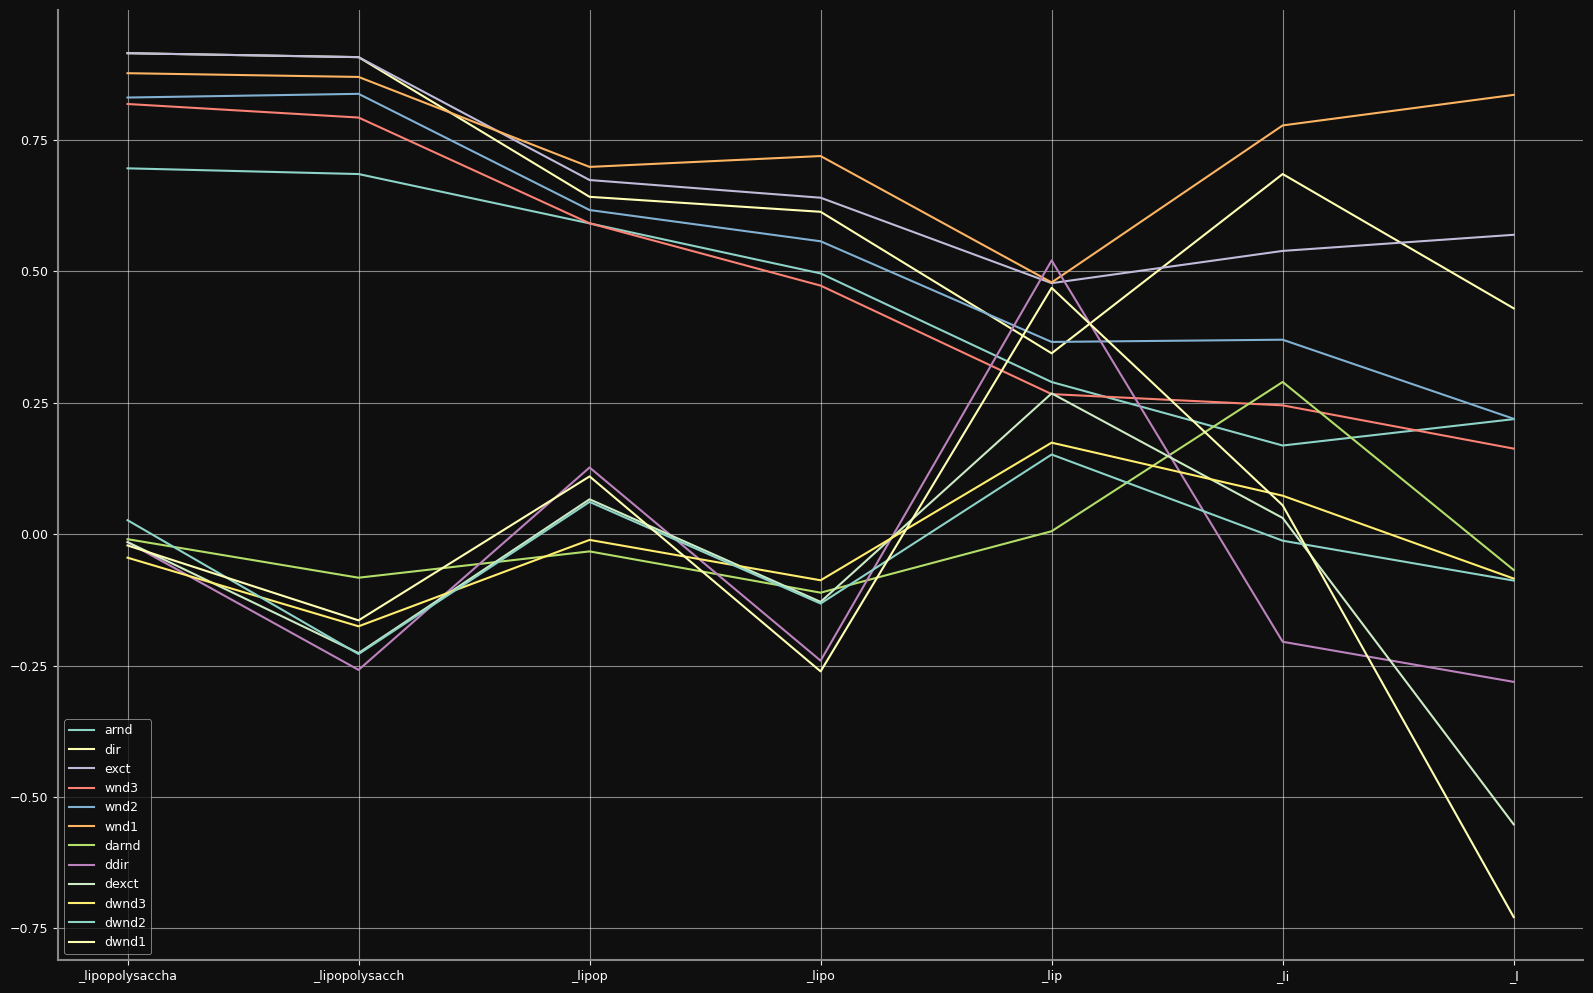

In [15]:

afx = '_lipopolysaccha'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

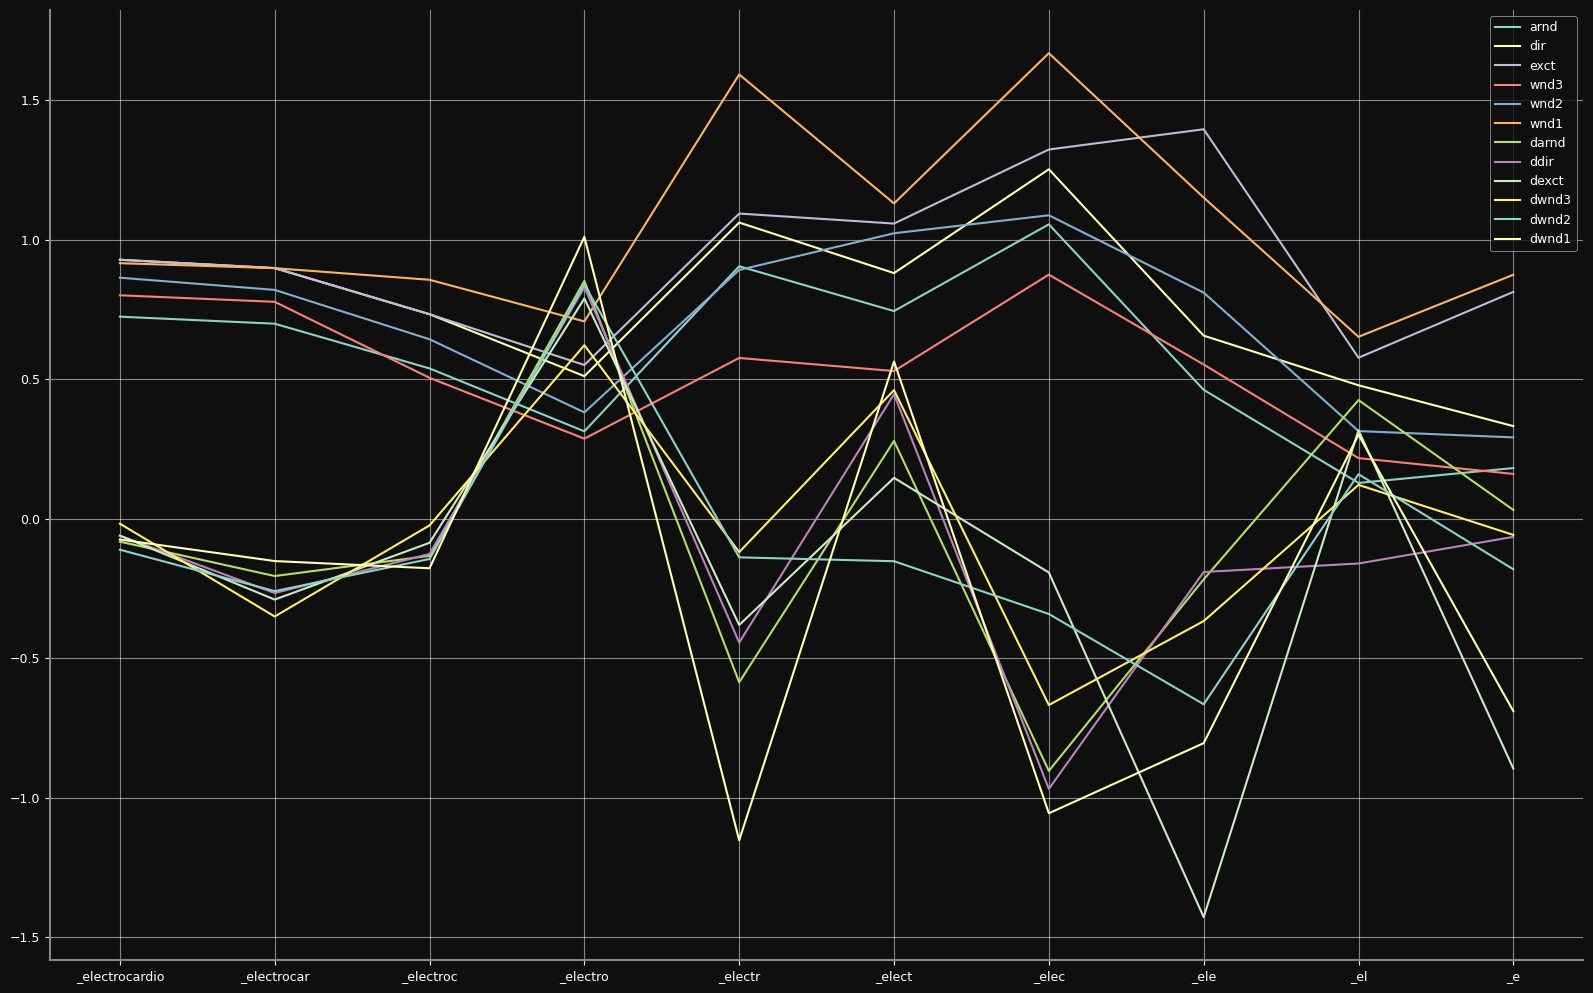

In [16]:
afx = '_electrocardio'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

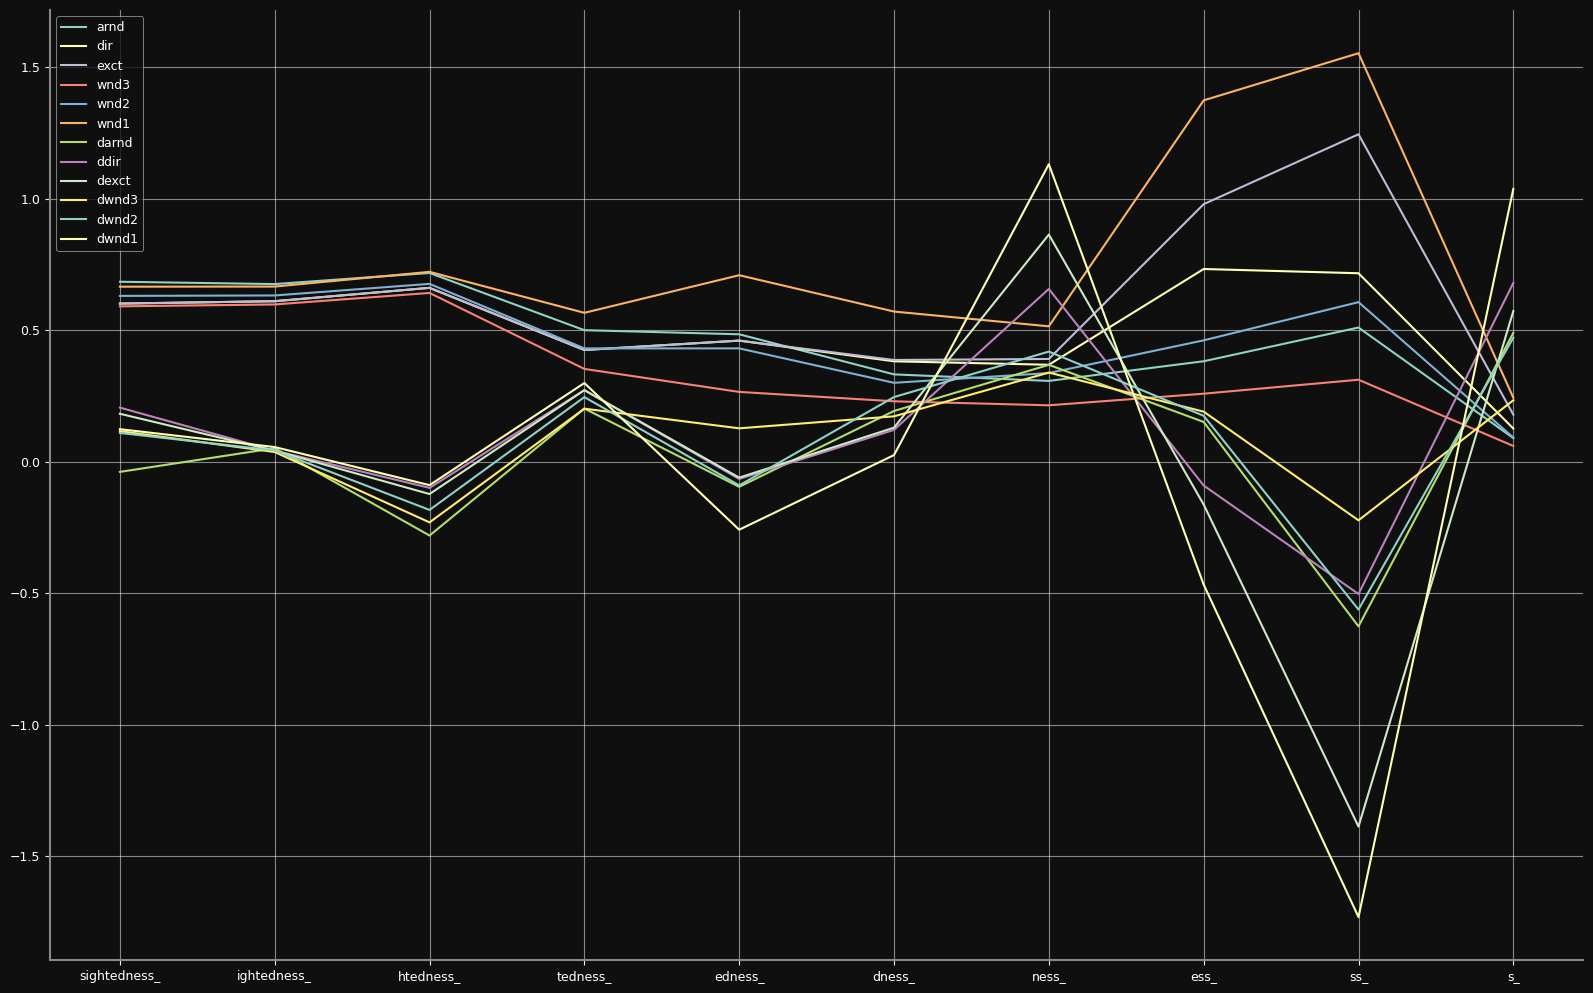

In [18]:
afx = 'sightedness_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

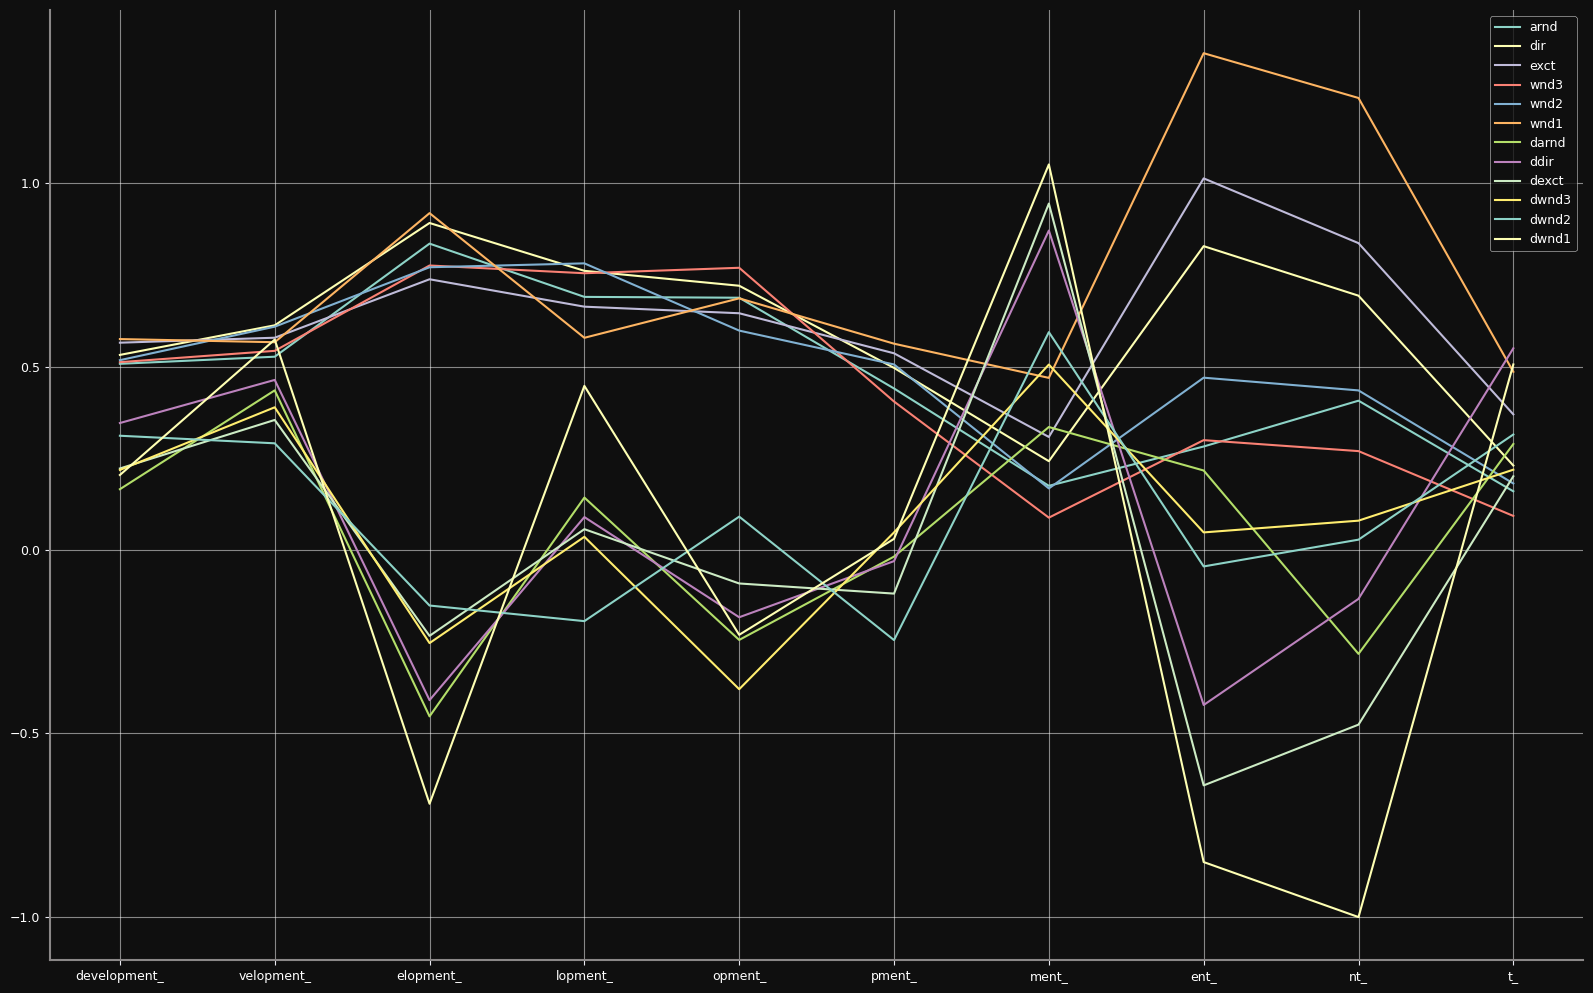

In [19]:
afx = 'development_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

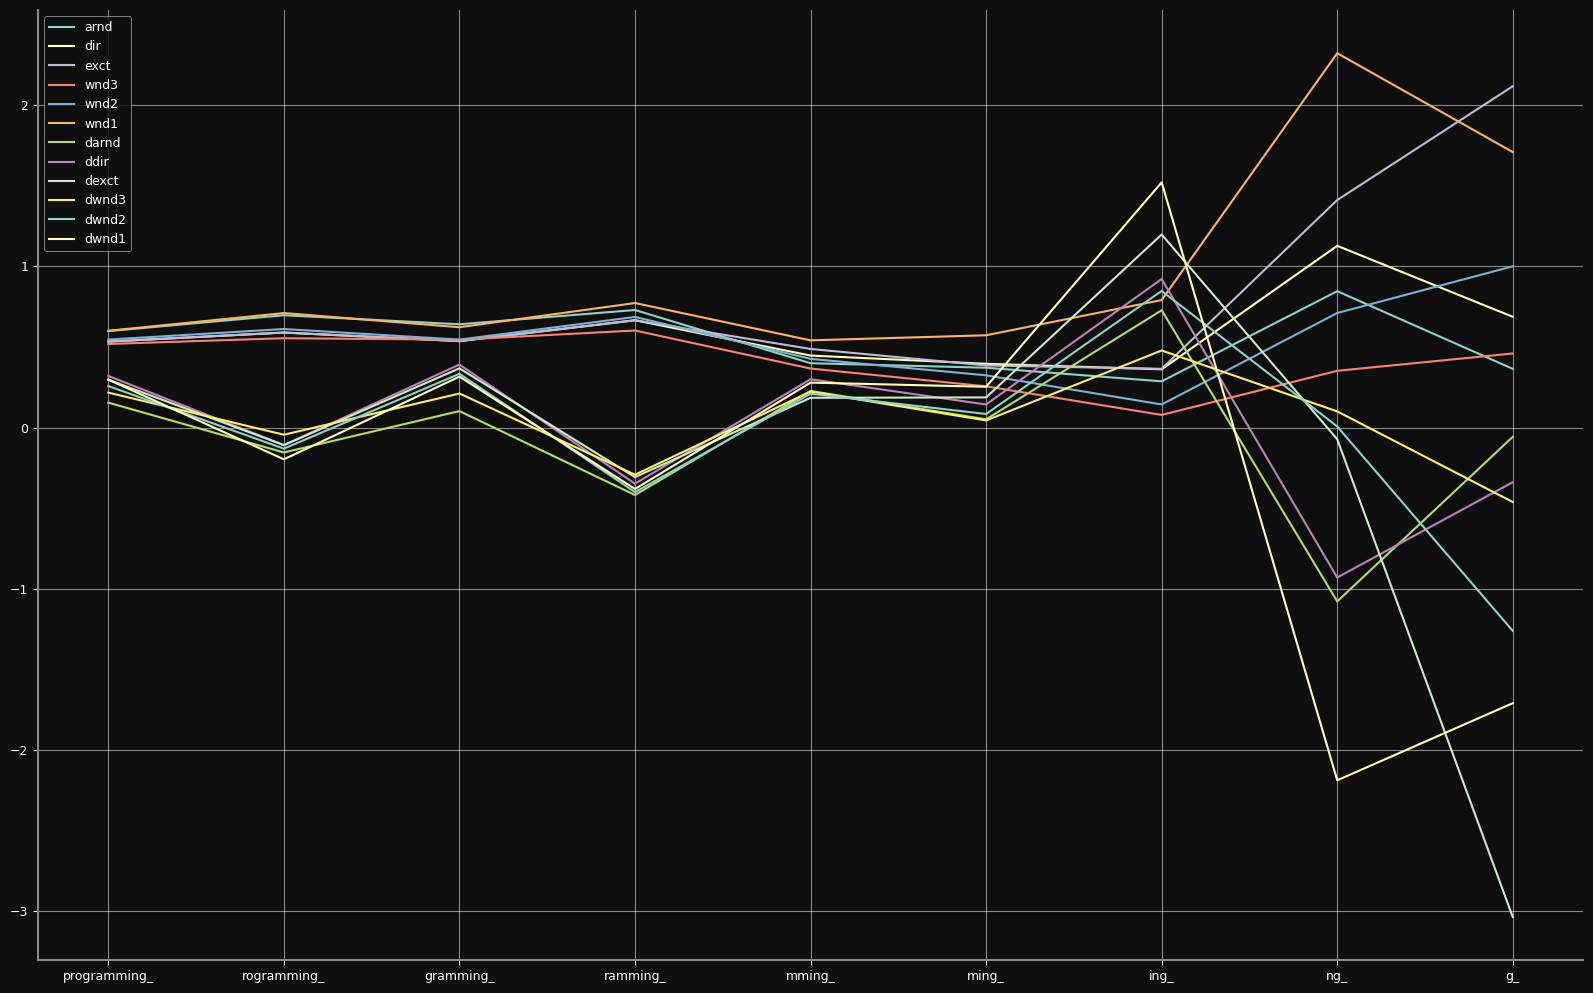

In [20]:
afx = 'programming_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

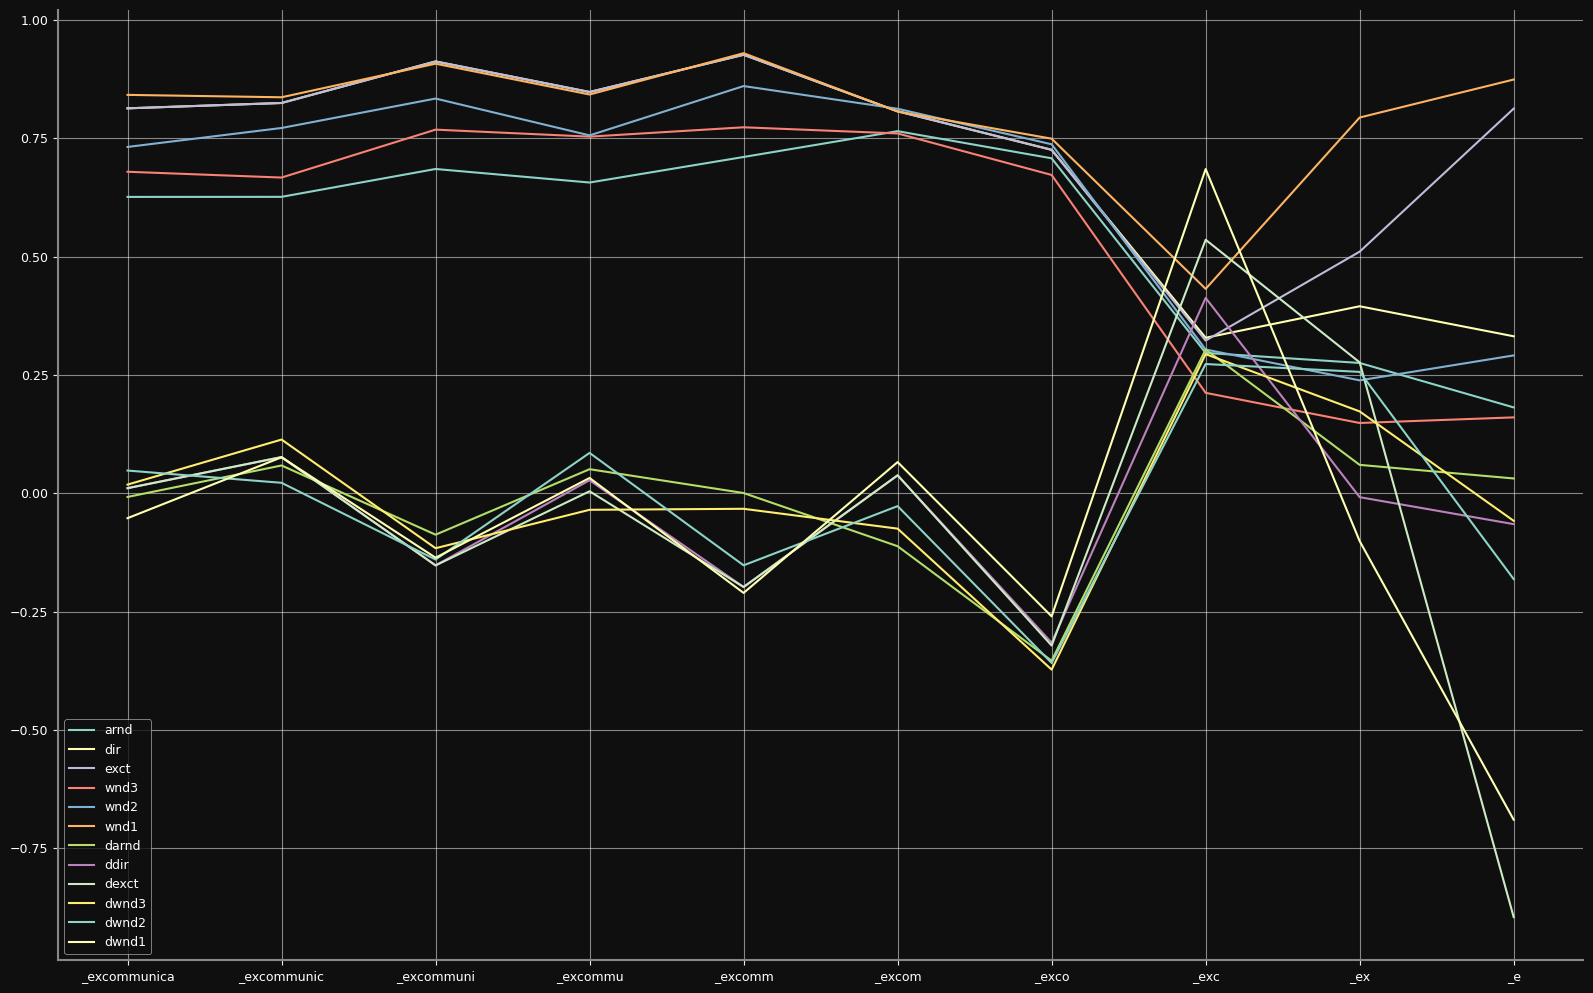

In [21]:
afx = '_excommunica'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

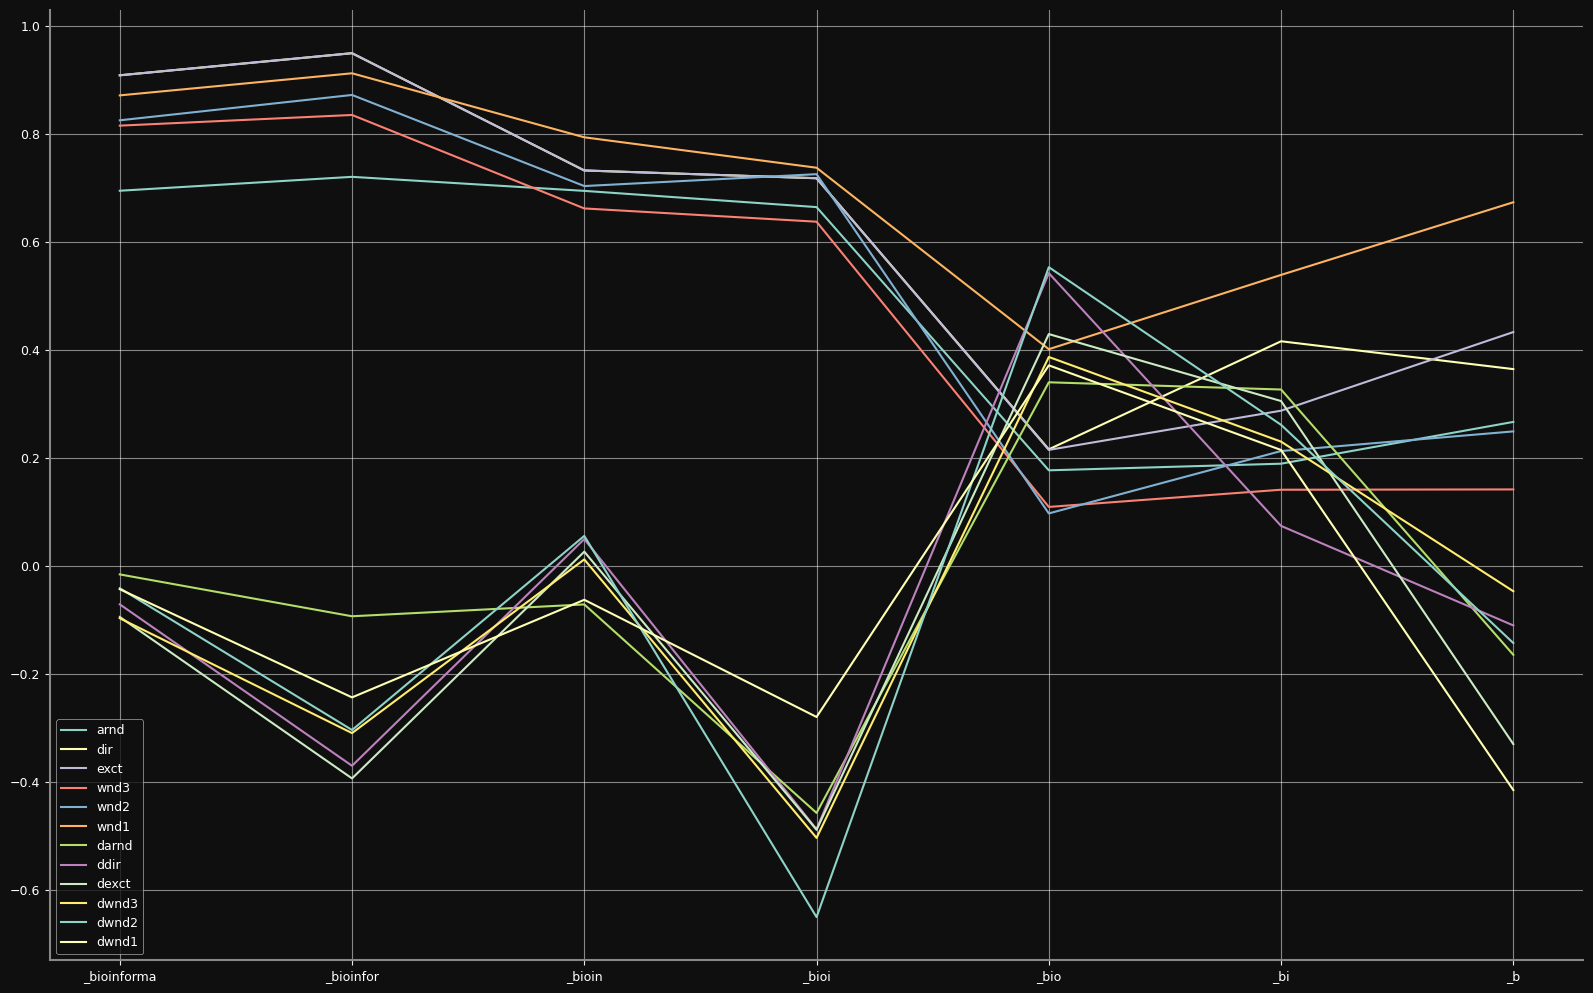

In [22]:
afx = '_bioinforma'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

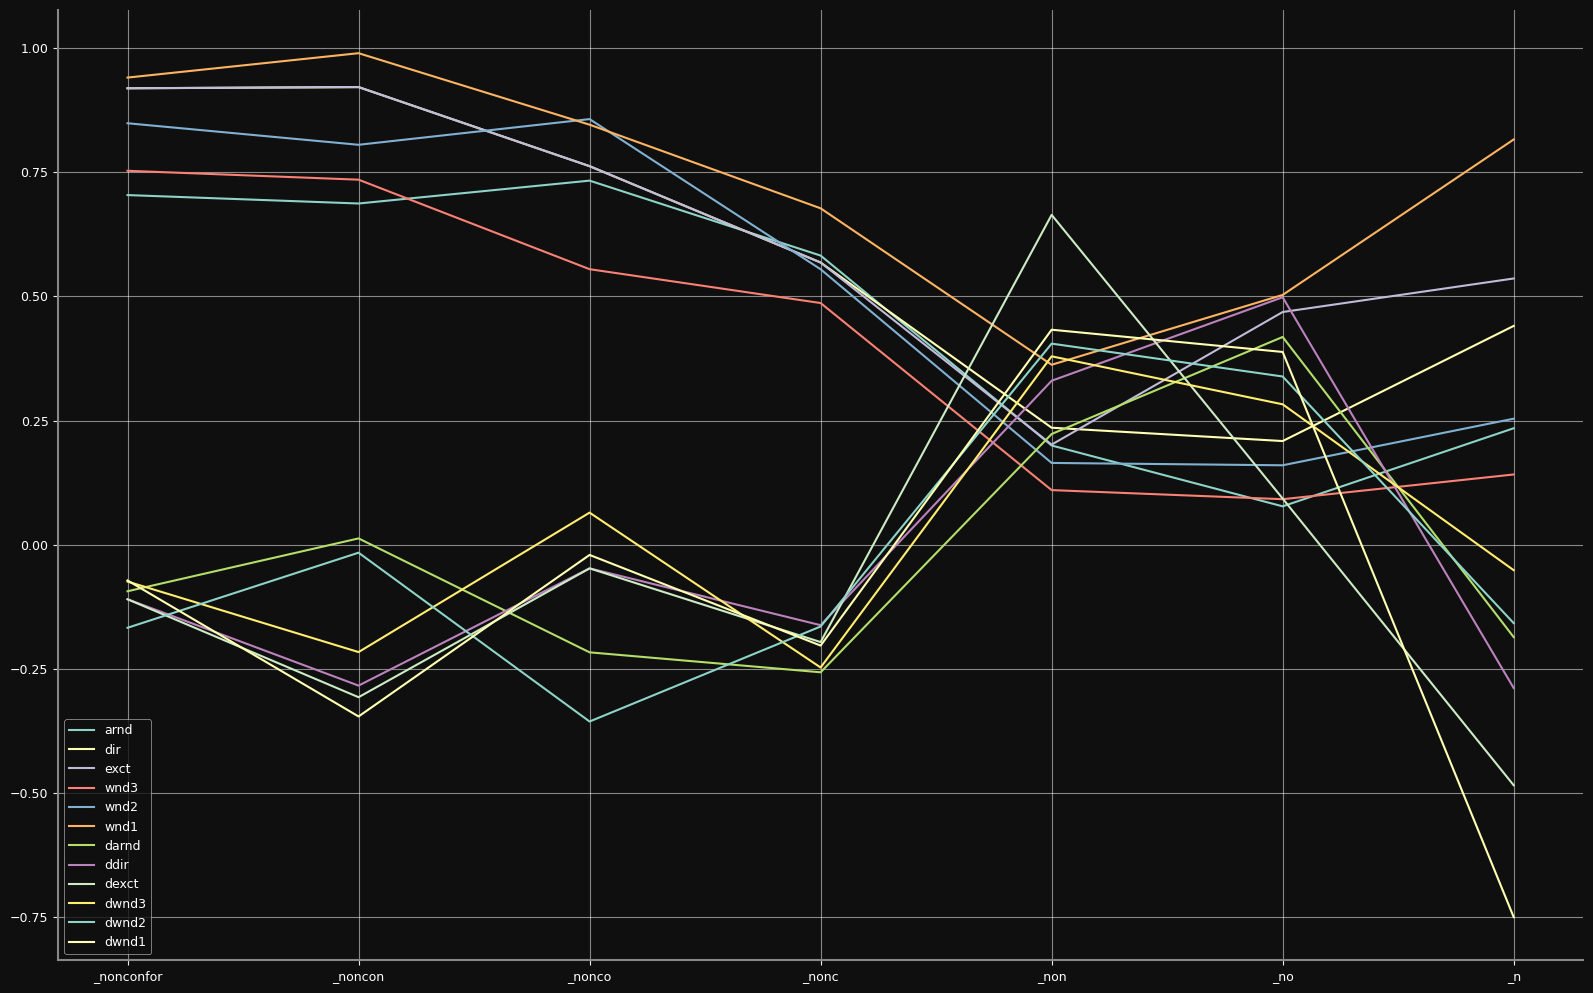

In [23]:
afx = '_nonconfor'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

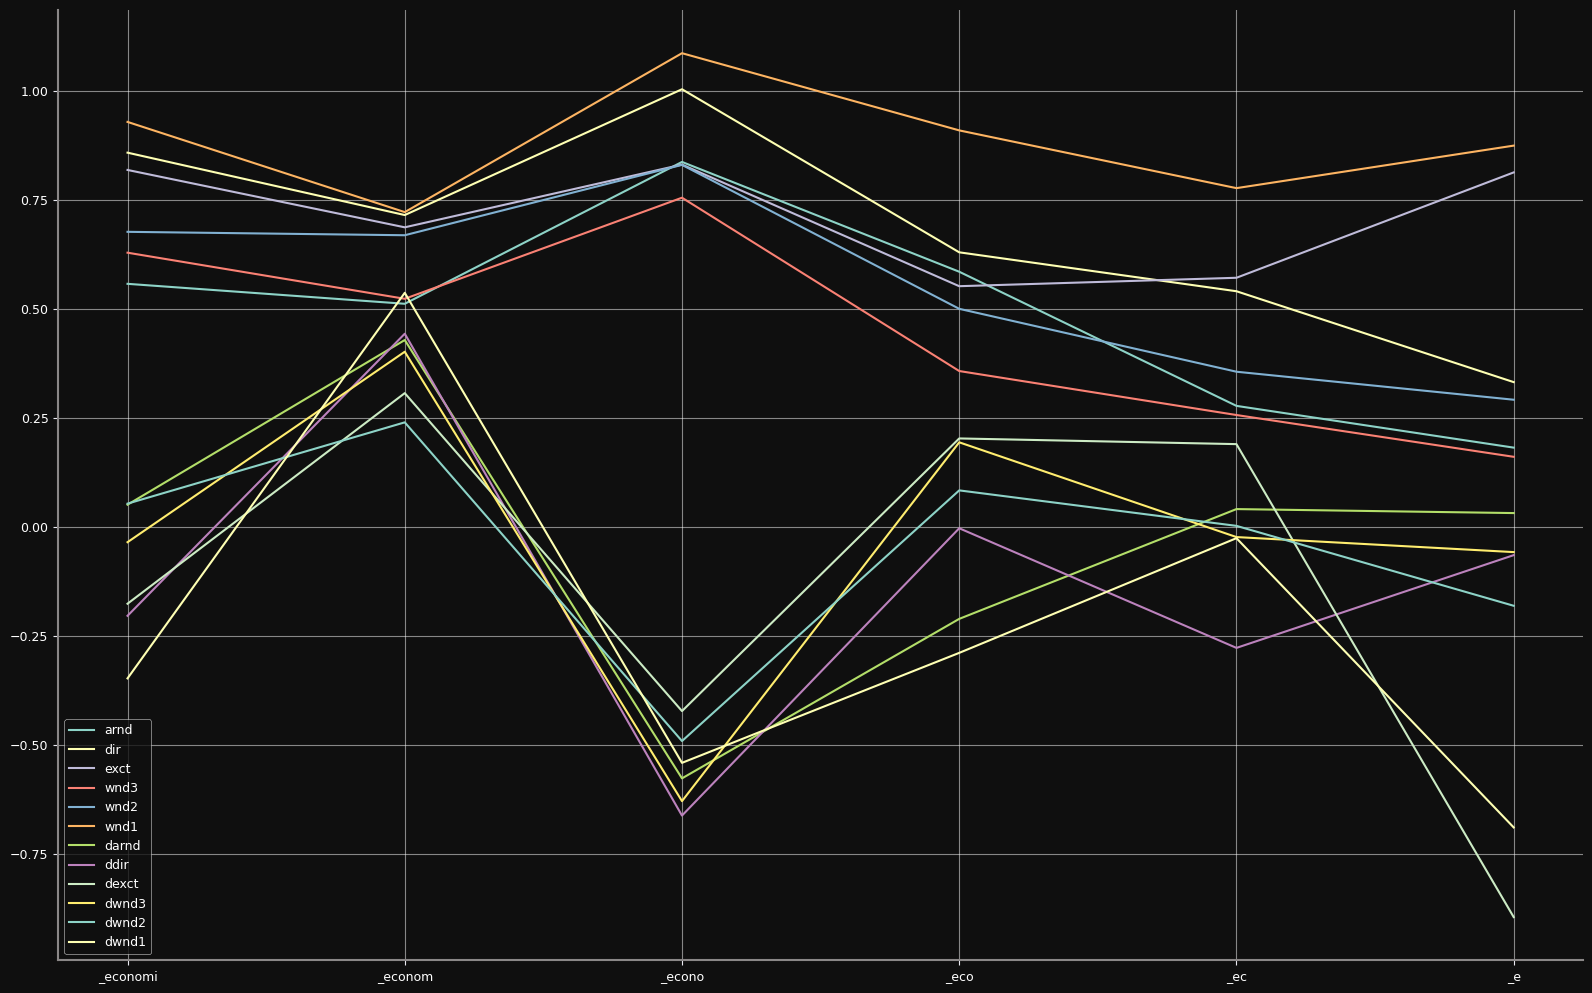

In [24]:
afx = '_economi'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

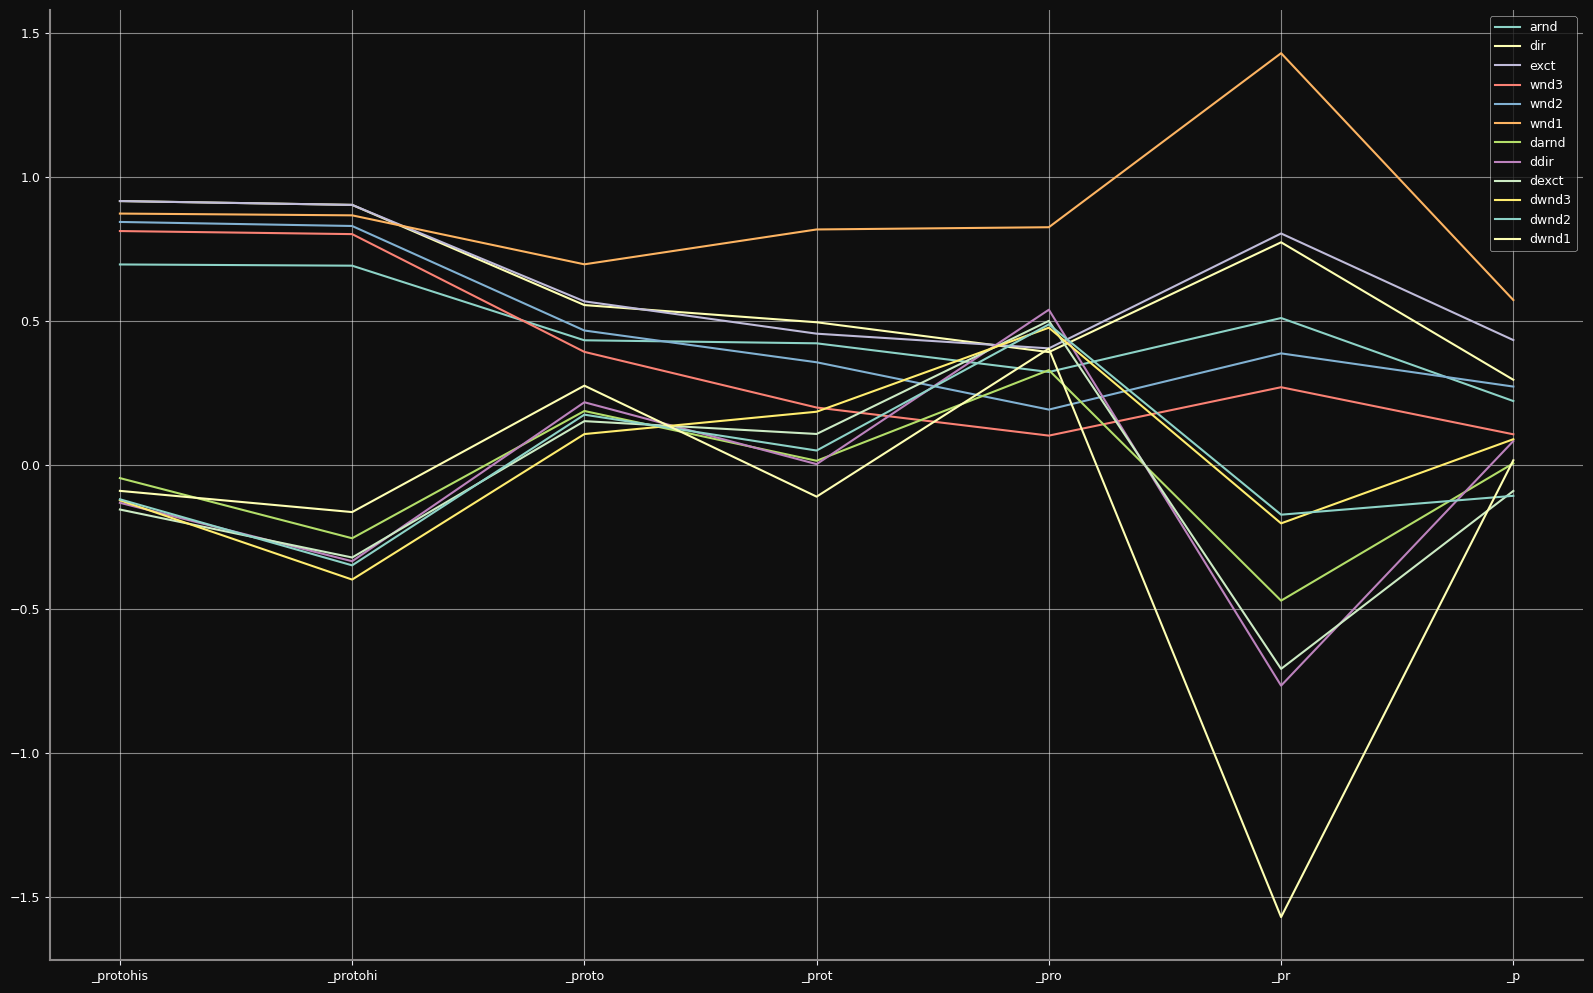

In [25]:
afx = '_protohis'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

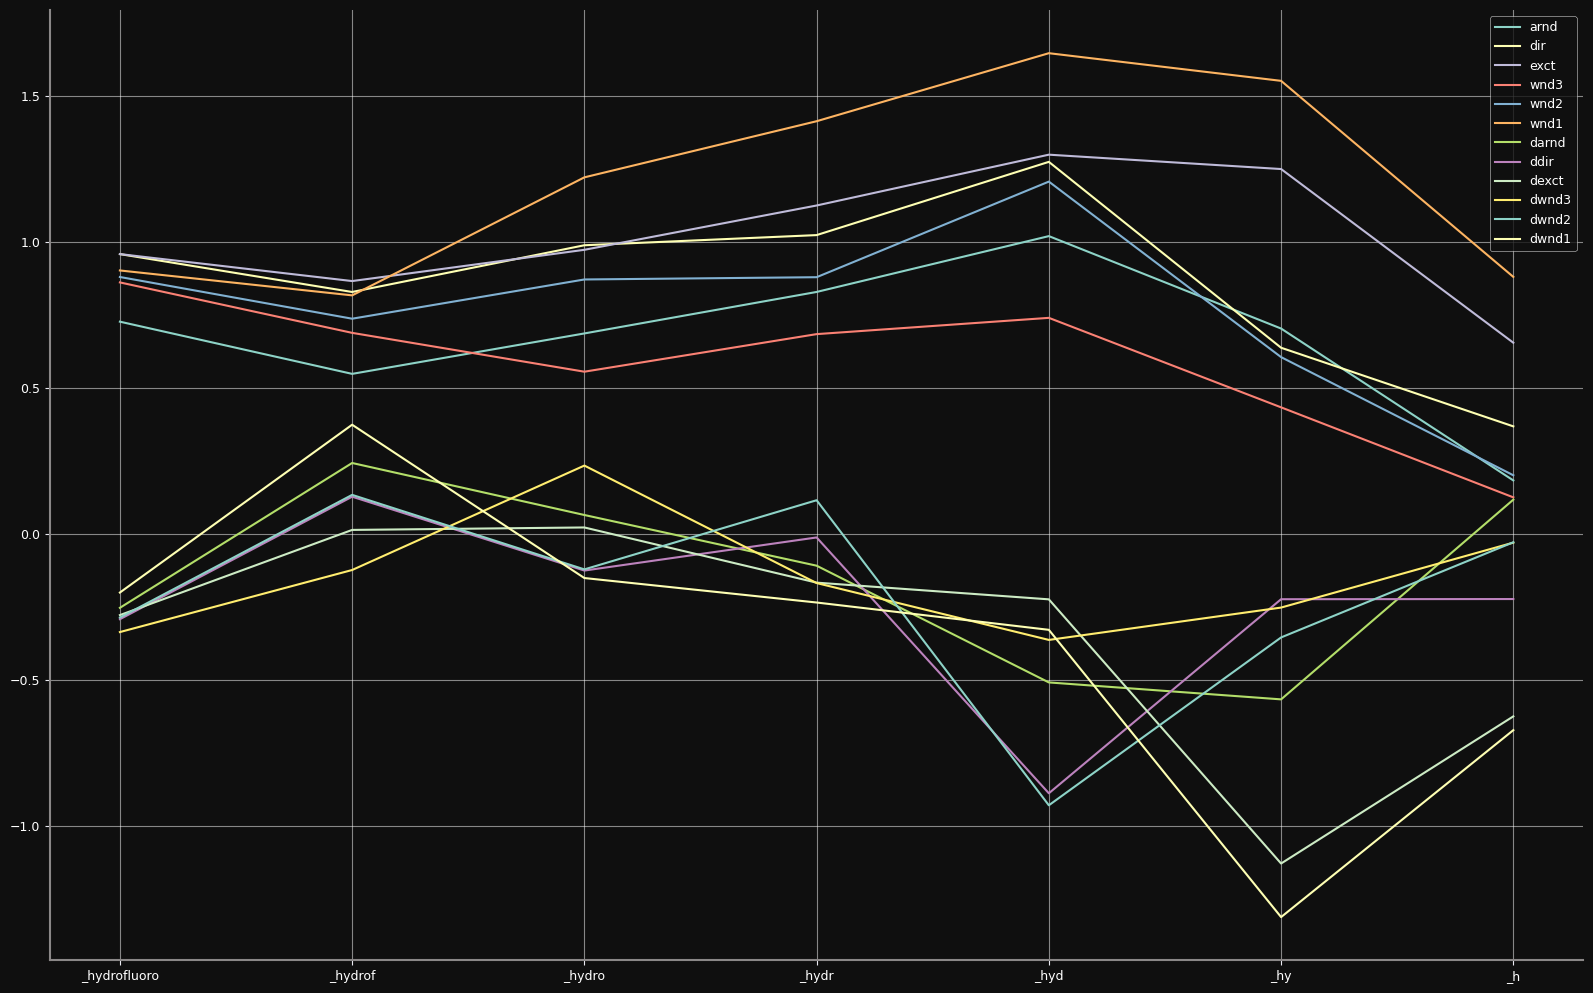

In [26]:
afx = '_hydrofluoro'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

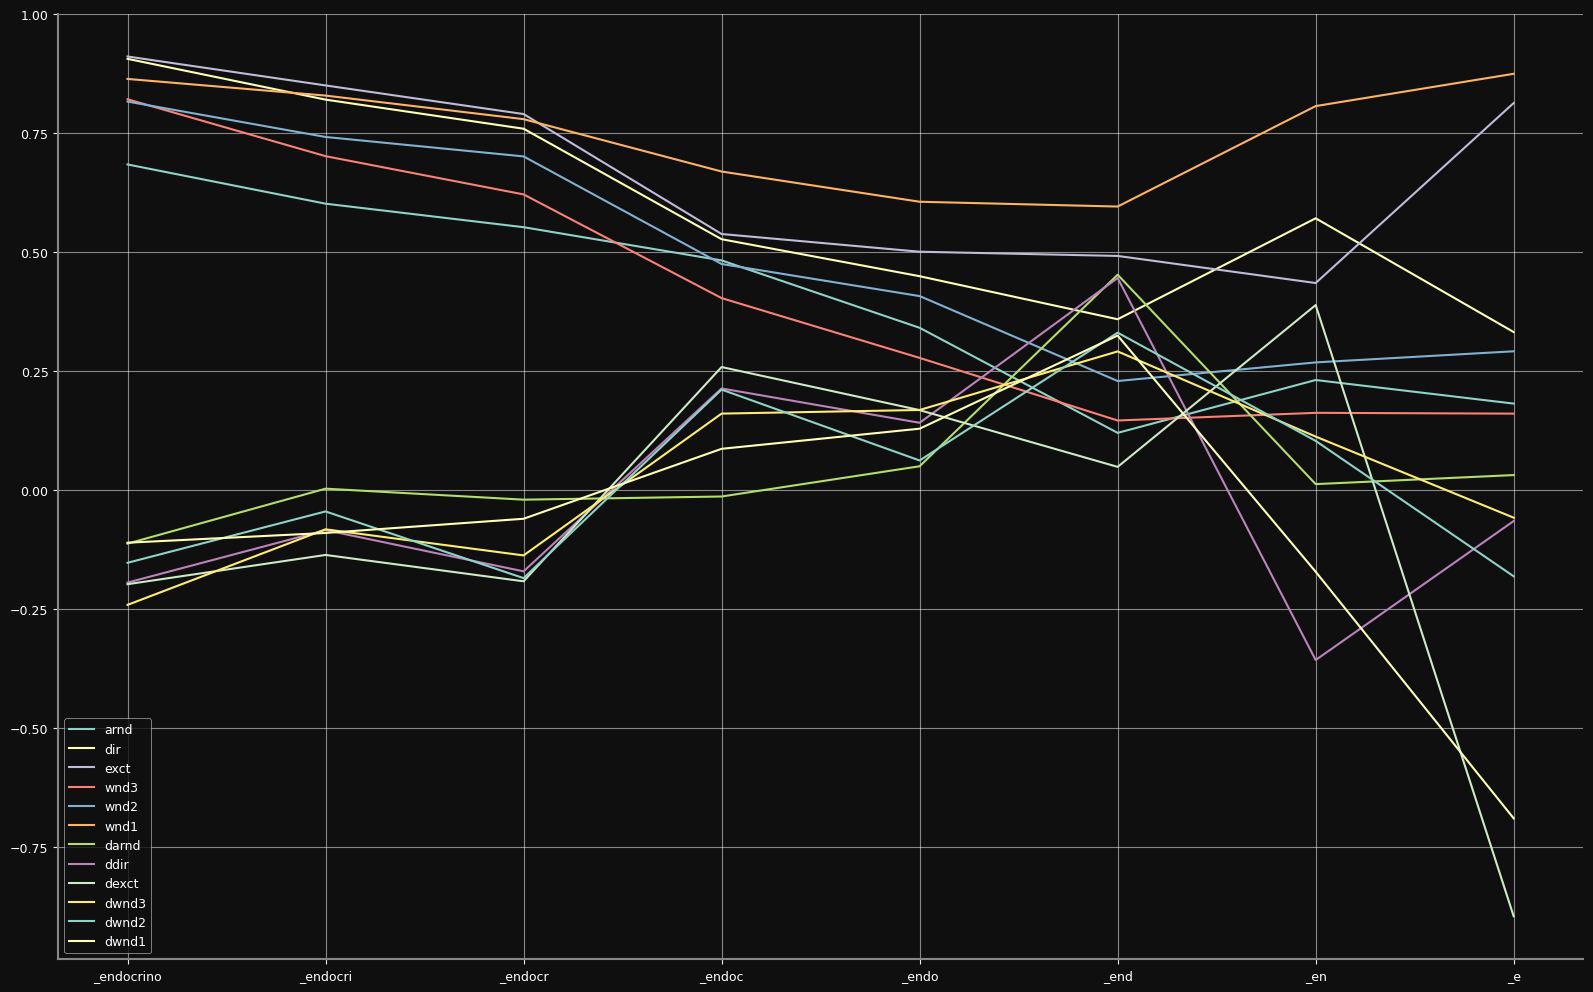

In [27]:
afx = '_endocrino'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

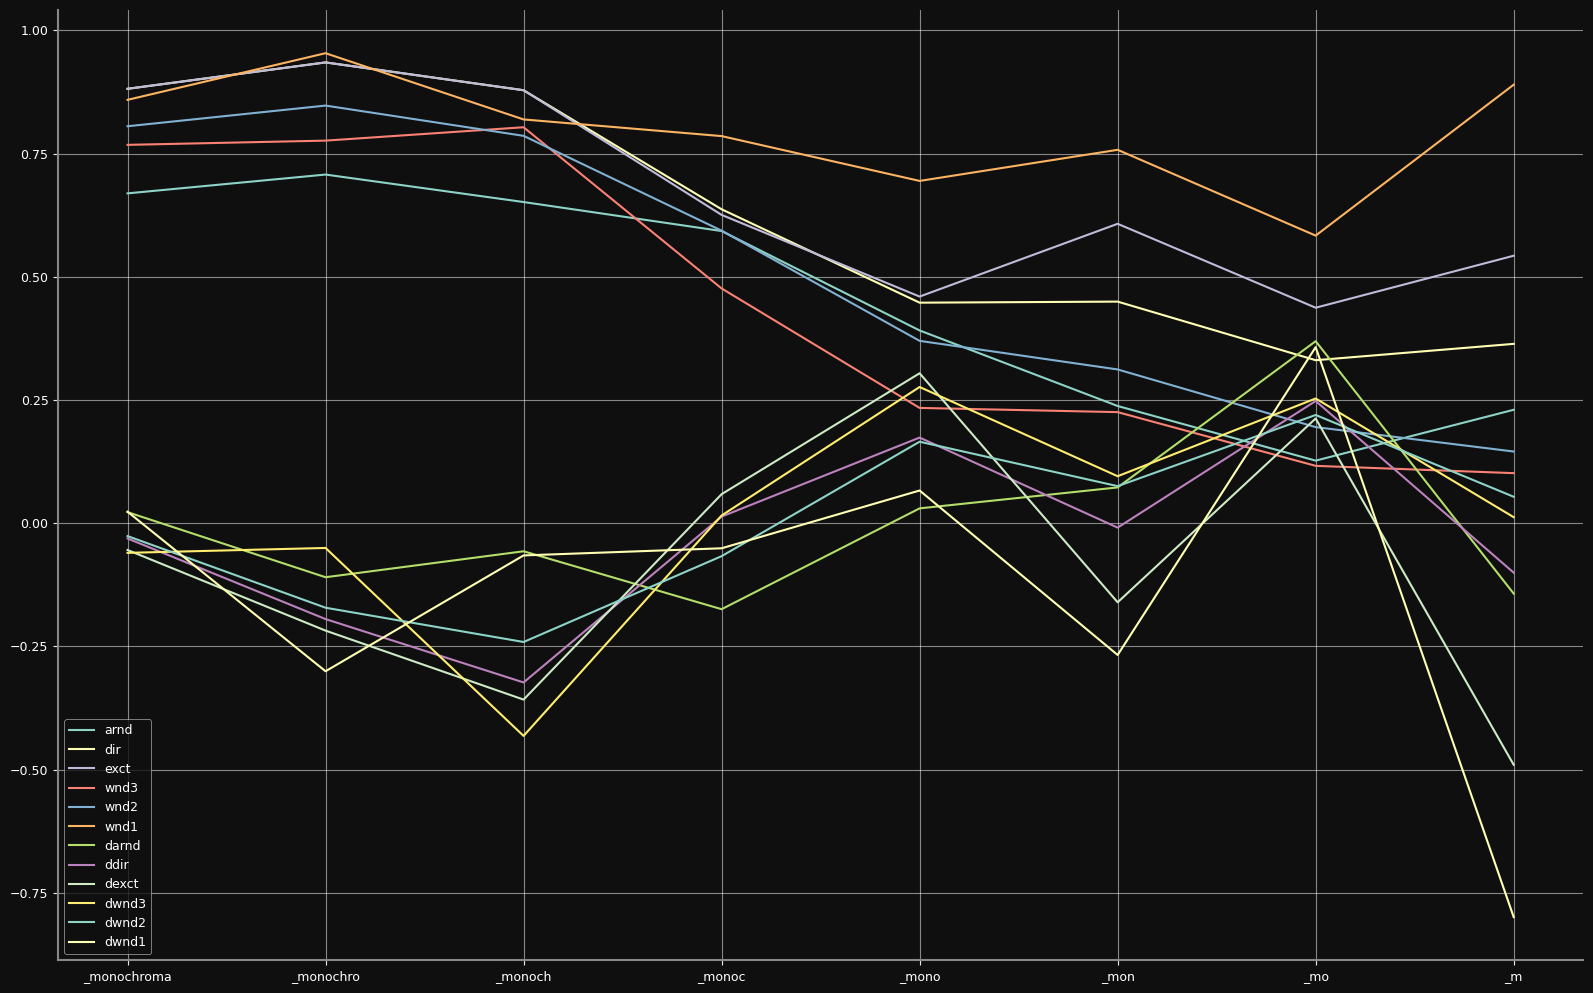

In [28]:
afx = '_monochroma'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

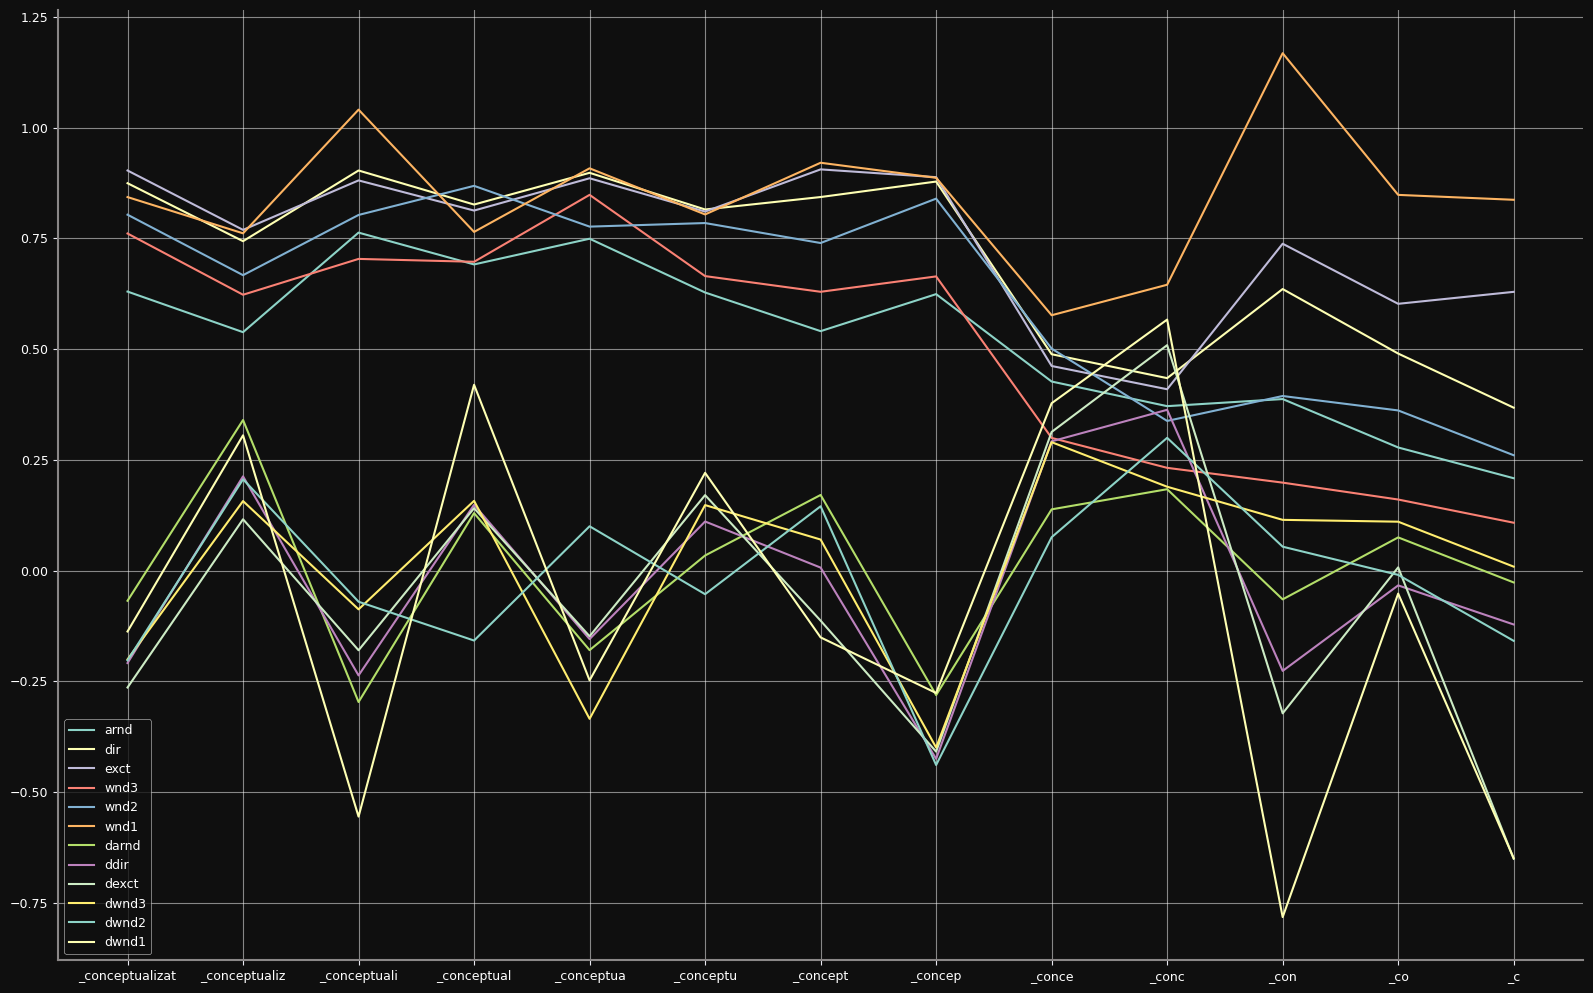

In [29]:
afx = '_conceptualizat'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

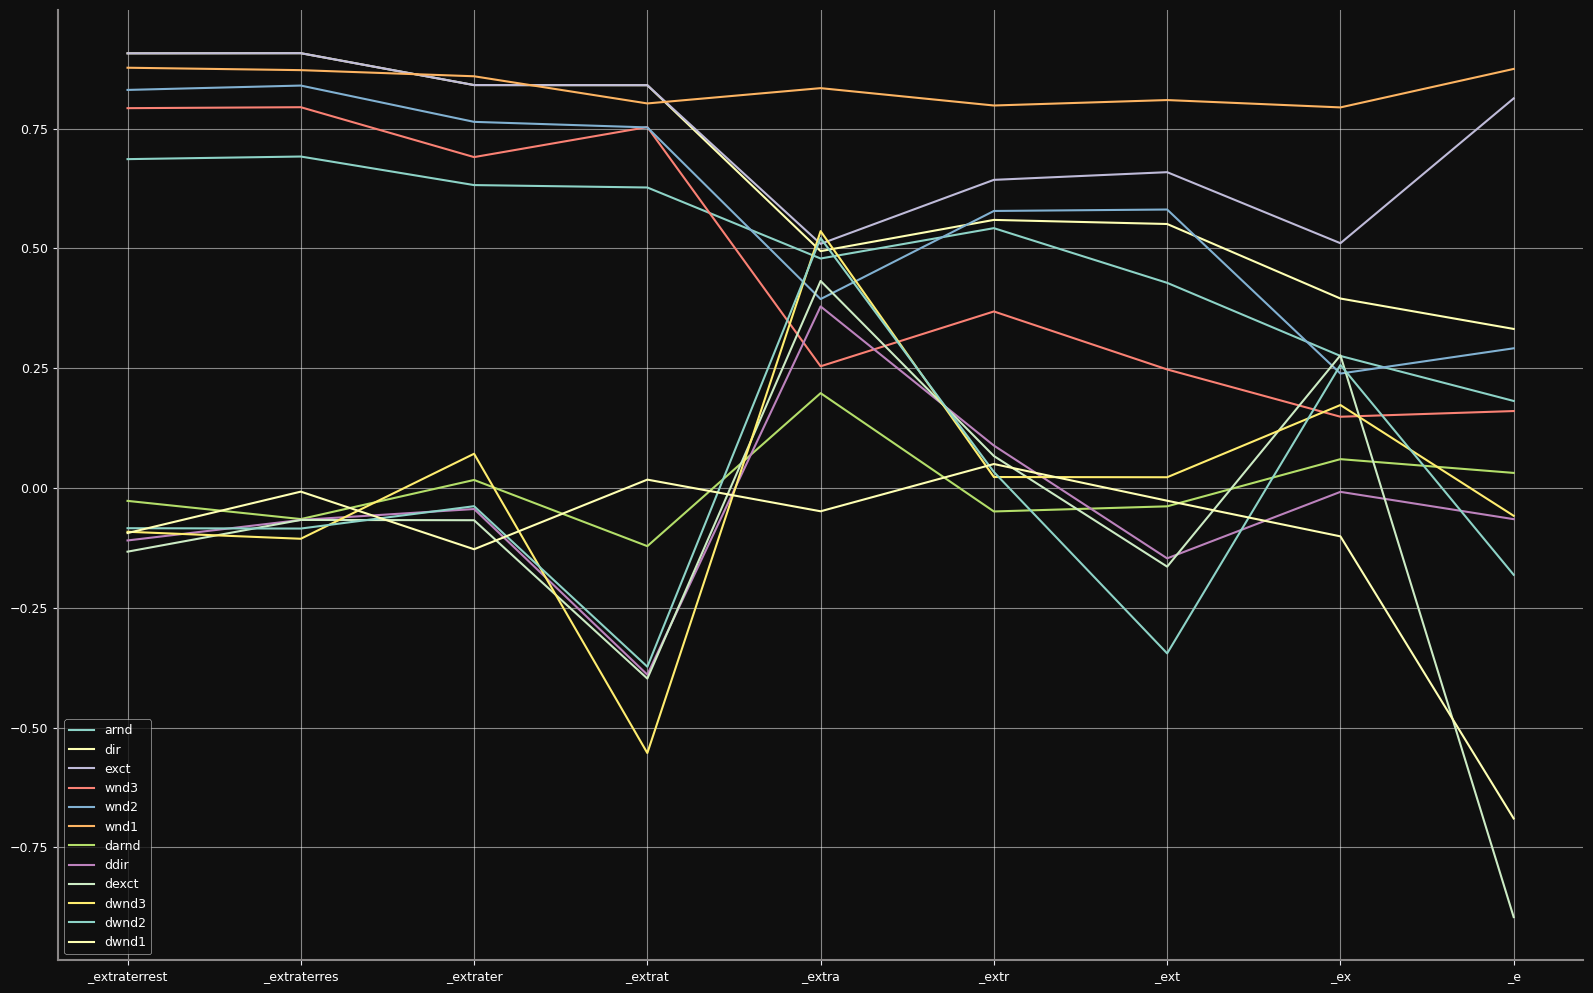

In [30]:
afx = '_extraterrest'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

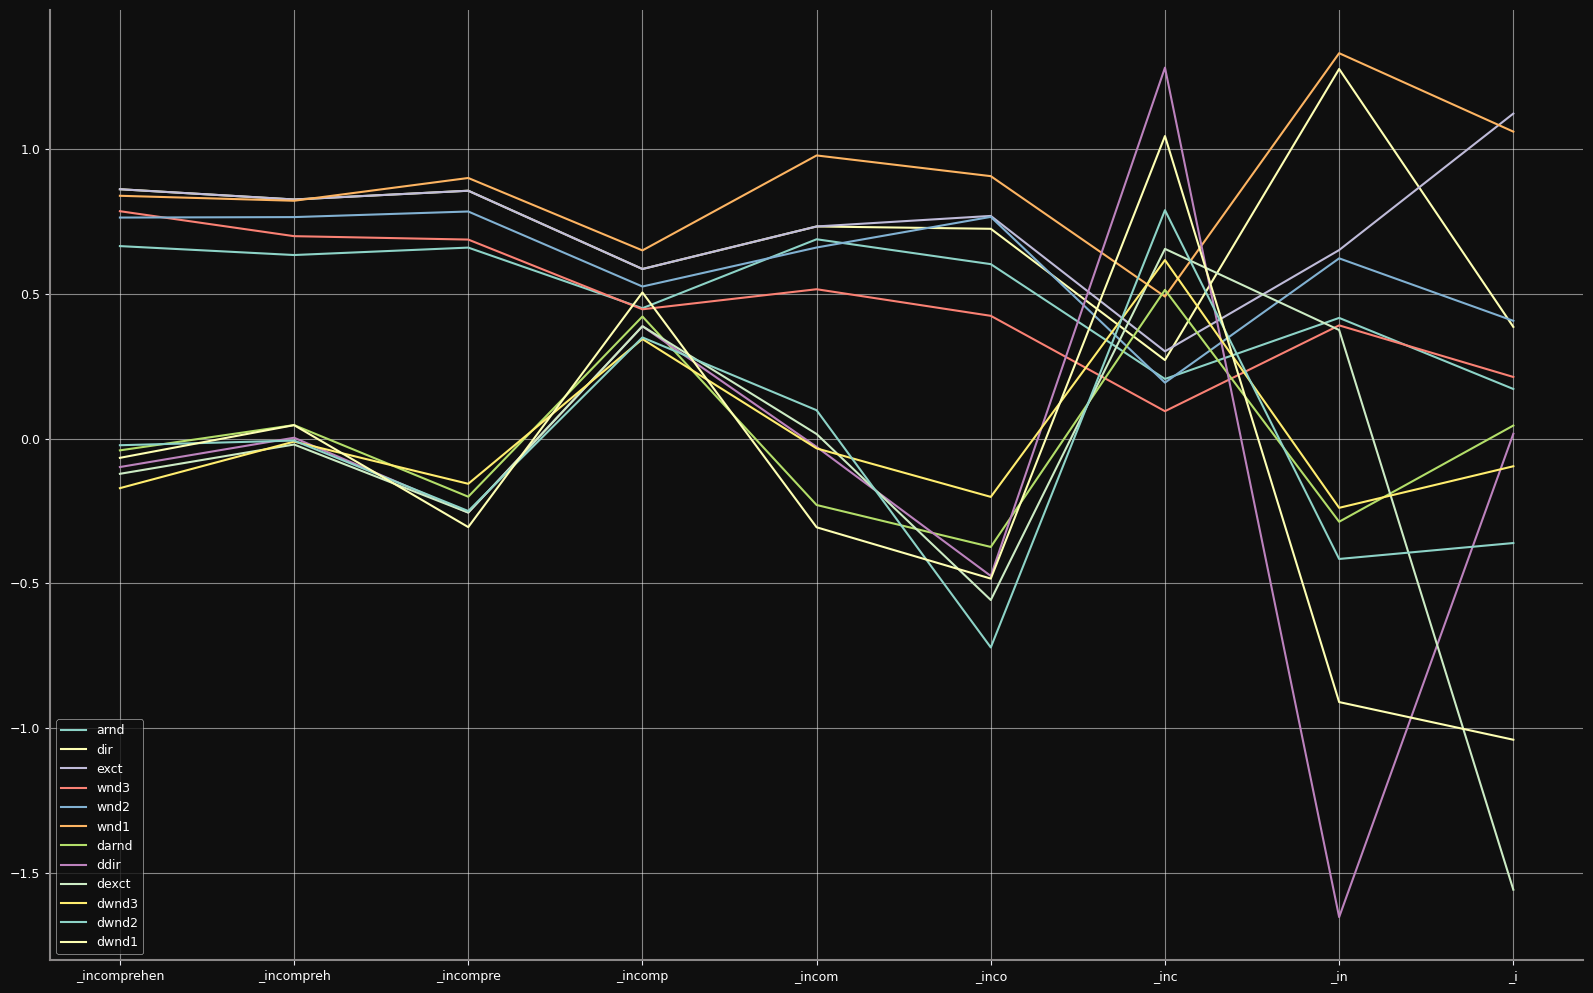

In [31]:
afx = '_incomprehen'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

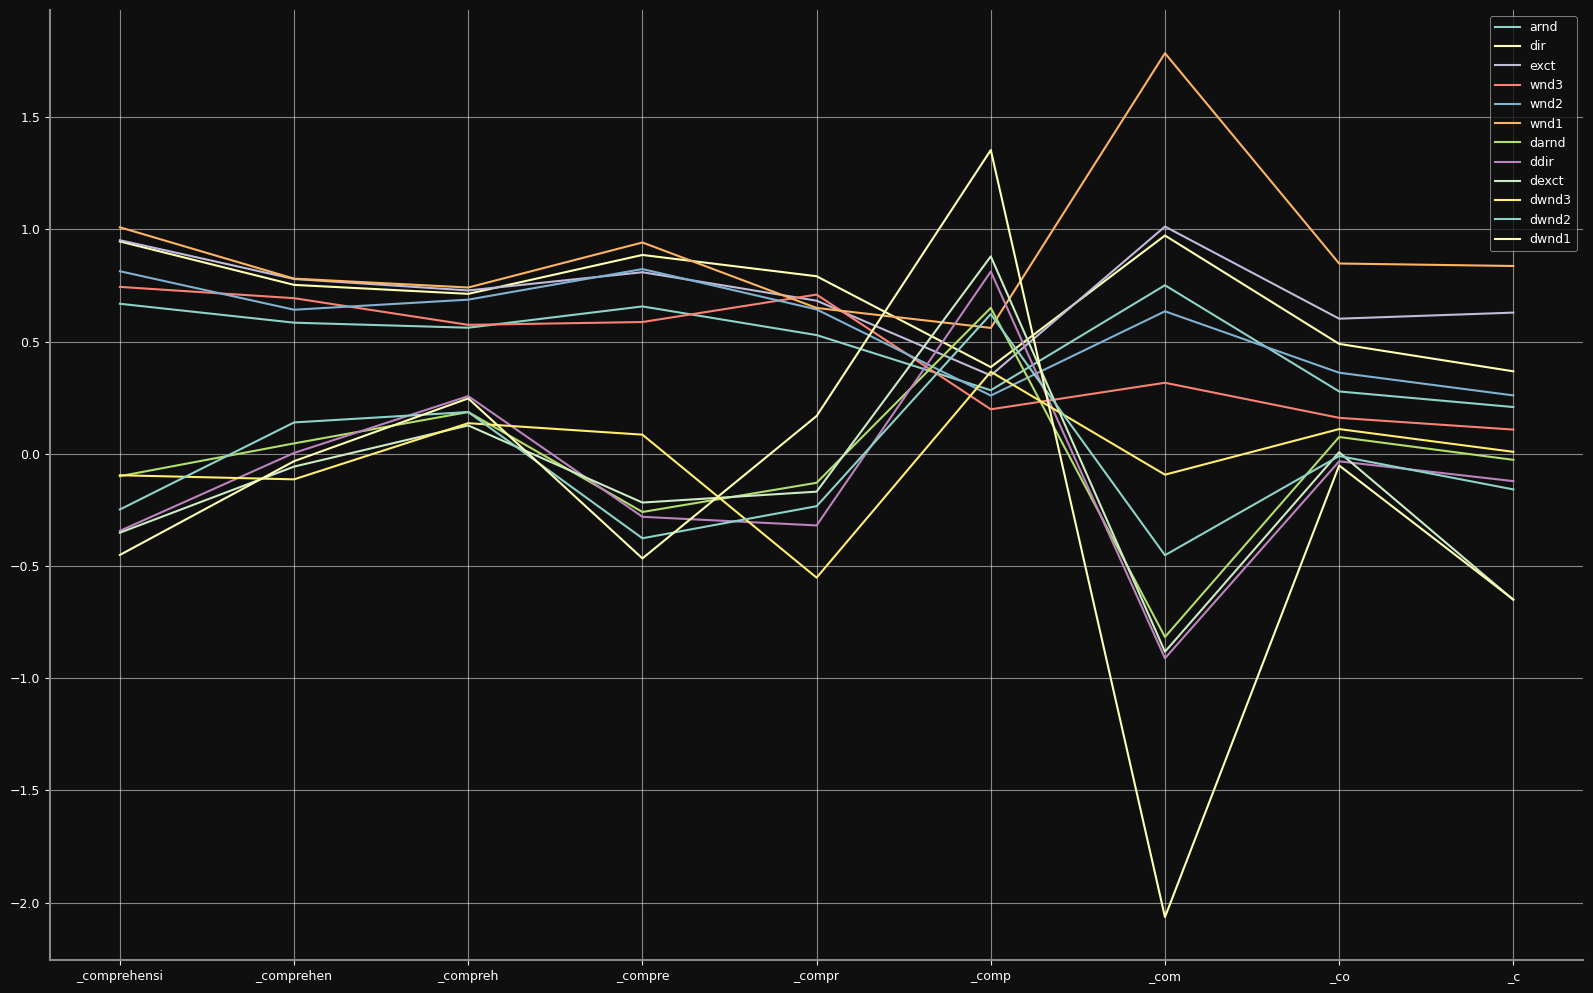

In [32]:
afx = '_comprehensi'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[w]], *[np.mean(x) for x in rntp[w].T], *[np.mean(x) for x in drntp[w]], *[np.mean(x) for x in drntp[w].T]] for w in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['arnd', 'dir', 'exct', 'wnd3', 'wnd2', 'wnd1', 'darnd', 'ddir', 'dexct', 'dwnd3', 'dwnd2', 'dwnd1'])

In [ ]:
def compress(oafx, window=1, dbg=False, t=full_words):
    cnt = Counter()
    if oafx[0] == '_': pre = True
    else: pre = False
    if len(oafx) == 1:
        for x in [x for x in t if x[0] == '_']:
            cnt[x[1]] += 1
        for x in [x for x in t if x[-1] == '_']:
            cnt[x[-2]] += 1
    else:
        afx = oafx.strip('_')
        if pre:
            group = [x.split(afx)[1].strip('_') for x in t if afx in x]
            for x in group:
                idx = min(len(x), window)
                cnt[x[:idx]] += 1
        else:
            group = [x.split(afx)[0].strip('_') for x in t if afx in x]
            for x in group:
                idx = min(len(x), window)
                cnt[x[-idx:]] += 1
    if '' in cnt: cnt.pop('')
    return Counter({x[0]: x[1] for x in cnt.most_common() if x[1] > 1})

def con_node(x, dbg=False):
    idx = 1
    if x[-1] == '_':
        while idx <= len(x):
            if x[idx:] in nodes:
                y = (x, x[idx:])
                break
            idx += 1
        else:
            return (x, '_', 2)
        if dbg: print(y[0][idx:])
        while idx <= len(y[0]):
            if len(y[0][idx:]) == 1:
                tmp = sfx1
            else:
                tmp = compress(y[0][idx:], t=tf2)
            if y[0][idx-1:][0] in tmp:
                return (*y, tmp[y[0][idx-1:][0]])
            idx += 1
    else:
        while idx <= len(x):
            if x[:-idx] in nodes:
                y = (x, x[:-idx])
                break
            idx += 1
        else:
            return (x, '_', 2)
        if dbg: print(y[0][:-idx])
        while idx <= len(y[0]):
            if idx == 1:
                target = y[0]
            else:
                target = y[0][:-idx+1]
            if len(target) == 1:
                tmp = pfx1
            else:
                tmp = compress(target[:-1], t=tf2)
            if target[-1] in tmp:
                return (*y, tmp[target[-1]])
            idx += 1
    return (x, '_', 2)

cdct = {1: 'k',2: '#08f32a',3: '#08f32a',4: '#14dc81',5: '#14dc81', 6: '#19dbdb',7: '#19dbdb',8: '#0e84e1',9: '#0e84e1'}
#nodes = sorted(tf2, key=lambda x: len(x), reverse=True)
nodes = sorted(search('ing', tf2), key=lambda x: len(x), reverse=True)
nodes.append('_')
edges, nsize, ewidth, eweights, ncolors = [], [], [], [], []

for x in nodes:
    out = con_node(x)
    edges.append((out[0], out[1]))
    eweights.append(out[2])
for x in nodes:
    nsize.append(30*(np.log2(sum(compress(x).values()))-1))
for x in eweights:
    ewidth.append(np.log2(x) / 7.5)
for x in nodes:
    if len(x) in cdct:
        ncolors.append(cdct[len(x)])
    else:
        ncolors.append('#808b96')
atree = nx.Graph()
atree.add_nodes_from(nodes)
atree.add_edges_from(edges)
pos = nx.nx_agraph.graphviz_layout(atree, prog="twopi", root='_', args='-Goverlap=scalexy')
fig, ax = plt.subplots(figsize=(50, 28))
nx.draw_networkx(
    atree, 
    pos=pos,
    ax=ax, 
    with_labels=True, 
    width=ewidth, 
    node_size=nsize, 
    node_color=ncolors, 
    edge_color='w', 
    font_color='w',
    font_size=10
)